# Random Forest Model Development

This notebook goes through model development for a Random Forest (RF) regressor designed for high-resolution nutrient prediction in the Southern Ocean. The RF model is trained on data from ocean autonomous profilers, called Argo floats and Seagliders, which take measurements of ocean properties as they are carried by the currents. (This is a gross oversimplification, and further detail is provided in Song et al. (2024) [in progress, AIES].)


The next notebook, `../Analysis_RandomForest.ipnyb` will use this output to analyze the performance.

# Introduction: Random Forest Regression

Random Forest (RF) regression is a supervised machine learning method that averages the results over a "forest" of $n$ decision trees for final prediction. Each decision tree determines a series of conditions at each node based on a set of observed variables, referred to as features. For regression, the trees find conditions that best separate the target observations into branches with the least variance. 

Formally, observations are sorted into $j$ regions of predictor space ($R_j$) during training. Following the notation in James et al. (2013), each node in the tree considers a split into two new regions based on a condition $s$ for a predictor $X_j$:
\begin{equation}
\begin{split}
R_1(j,s) = \{X|X_j < s\} \text{ and } R_2(j,s) = \{X|X_j \ge s\}, \\
\end{split}
\end{equation}
and each region is assigned a prediction value that is the average of all target variable values ($\hat{y}_{R_j}$ ) within $R_j$. The condition $s$ is chosen to minimize the residual sum of squares in the resulting bins:
\begin{equation}
\begin{split}
\sum_{i: \: x_i \in \: R_1(j,s)}{} (y_i-\hat{y}_{R_1})^2 \; + \sum_{i: \: x_i \in \: R_2(j,s)}{} (y_i-\hat{y}_{R_2})^2,
\end{split}
\end{equation}
where $y_i$ represents each observed value. During testing, validation, and prediction, RF sorts input observations into the regions and assigns them the value $\hat{y}_{R_j}$. One advantage of RF is that it limits the decision at each node split to a random subset of features. As a result, the trees in Random Forest are less correlated than those in a family of ``bagged'' trees which consider all possible features at all nodes. The RF method is therefore less prone to overfitting, especially on spatiotemporally biased data (Stock et.al (2022), Sharp et al. 2022). 

# PART 0: Import Packages and Plotting Parameters

In [1]:
# Data Structure/Organization Packages
import pandas as pd
import xarray as xr
import numpy as np
import numpy.ma as ma
import importlib

# Machine Learning/Statistics Packages
import scipy
from scipy.stats import kde
from scipy.stats import iqr

from sklearn import linear_model
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

# Plotting Packages
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patheffects as pe
import seaborn as sns
from labellines import labelLine, labelLines

# Utility Packages
import random as rand
import os
import math
import itertools
# from scipy import interpolate
from tqdm import tqdm
from importlib import reload

# Oceanography Packages
import gsw
from cmocean import cm as cmo
import geopy.distance

In [2]:
# Modules
import mod_main as sg
import mod_L3proc as gproc     # for L3 grid processing
import mod_DFproc as dfproc    # for dataframe processing
import mod_plot as sgplot  

plt.rcParams.update(sgplot.my_params(16))

In [3]:
from mod_main import floatDF, shipDF
from mod_main import dav_659, dav_660
from mod_main import sgfloat, dav_float # sogos float (yd<205)
from mod_main import dav_6030 # long mld series for 5906030

from mod_RFR import mltraining, mlvalidation, mltest
from mod_RFR import var_list, model_list

In [4]:
from mod_RFR import RF_test, RF_validation

In [10]:
# Input glider data, which has already been quality controlled. 
sg659 = pd.read_csv('../data/glider/sg659_tsO2corr.csv')
sg660 = pd.read_csv('../data/glider/sg660_tsO2corr.csv')

# Dive-averaged glider data
df_659 = pd.read_csv('../data/glider/mldata_sg659.csv')
df_660 = pd.read_csv('../data/glider/mldata_sg660.csv')
dav_659 = pd.read_csv('../data/glider/sg659_diveavg.csv')  
dav_660 = pd.read_csv('../data/glider/sg660_diveavg.csv')

# Float data: 
floatDF = pd.read_csv('../data/bgc-argo/mldata_floatDF_qc.csv')
sgfloat = floatDF[(floatDF.yearday<205) & (floatDF.wmoid==5906030)]
dav_float = pd.read_csv('../data/bgc-argo/sgfloat_diveavg.csv')

# Ouput of this notebook: 
# df_659 = pd.read_csv('RFpred_659_modG_split2023.csv')
# df_660 = pd.read_csv('RFpred_660_modG_split2023.csv')

# PART 1: Data Selection: Ocean Autonomous Profilers

## 1.0 Study Region

Here, we develop a regional model using SOGOS observations, GO-SHIP I06 bottle data and observations from six BGC-Argo floats (WMO: 5904469, 5904659, 5905368, 5905996, 5906031, 5906207), which provided coverage of the Antarctic Southern Zone (ASZ) bounded by the Polar Front and Sea Ice Edge.  

The Seagliders sampled for 86 days, from May 1, 2019 to July 25, 2019, covering a region spanning approximately 30-40 E and 50-54 S as shown below. SG659 and SG660 completed 456 and 502 V-shaped dives, respectively, to approximately ~1000 m and sampled during both the descent and ascent. The gliders generally surfaced every 4-6 hours (profiles every 2-3 hours), while the BGC-Argo float sampled with a 5-day profiling frequency. The SOGOS float returned 16 profiles within the duration of the Seaglider mission. After being deployed along the 30E I06 cruise track around -51.5S, the three profilers were advected eastward by the Antarctic Circumpolar Current (ACC). The platforms pass through a standing meander region by the Southwest Indian Ridge (SWIR), which is a known hotspot of enhanced eddy kinetic energy (EKE) (balwada2024_Tracer, yung2022_Topographic). Further details on the deployment and the profilers' path from a high to low EKE region can be found in Dove et. al. (2021). 


In [5]:
from mod_plot import *

In [10]:
# Use correct delayed-time product
altimetry = xr.open_dataset('../data/satellite/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1714604183615.nc')
altimetry['eke'] = np.sqrt(altimetry.ugosa**2 + altimetry.vgosa**2)

# Use AVISO satellite data to see study bounds. OLD!!
# aviso = xr.open_dataset('../data/satellite/dataset-duacs-nrt-global-merged-allsat-phy-l4_1637011653931.nc')
# aviso['eke'] = np.sqrt(aviso.ugosa**2 + aviso.vgosa**2)

# Download fronts of the Antarctic Circumpolar Current
PF = pd.read_csv('../data/ACC_fronts/PF.csv', header=None)
SIF = pd.read_csv('../data/ACC_fronts/SIF.csv', header=None)
for csv in [PF, SIF]:
    csv.columns = ['lon', 'lat']

Global Ocean Gridded L 4 Sea Surface Heights And Derived Variables Reprocessed 1993 Ongoing:


https://data.marine.copernicus.eu/product/SEALEVEL_GLO_PHY_L4_MY_008_047/download

https://doi.org/10.48670/moi-00148


### Figure: Study Region

(a) Trajectories for Seagliders SG659 and SG660 are shown in blue and magenta, respectively. 
Yellow diamonds denote locations of the float profiles. 

(b) Expanded view of the float (yellow) and glider SG660 (magenta) as they traverse from the high EKE region (yeardays<150) to the low EKE region (yeardays<170). 
Magenta text indicates yearday of the subset of observations highlighted in purple. Background colored by EKE [m^2/s^2] averaged over the deployment period.

In [ ]:
# PAPER SUBPLOT FIG: Plot the entire deployment paper figure

fs = (7,8)
fig, axs = plt.subplots(2,1, figsize=fs, layout='constrained')
axs = axs.flatten()
sgfloat = sgfloat[sgfloat.yearday<205]

# START HERE
for ax in [axs[0]]:
        datestart='2019-04-30'
        dateend='2019-07-25'
        lat1=-56.8; lat2=-43
        lon1=19; lon2=41
        data_sat = altimetry.sel(time=slice(datestart, dateend))
        data_sat = data_sat.sel(latitude=slice(lat1, lat2))
        data_sat = data_sat.sel(longitude=slice(lon1, lon2))
        avg_altimetry = data_sat.mean(dim='time')

        #background EKE
        sca = avg_altimetry.eke.plot(ax=ax, cmap='bone_r', alpha=0.8, add_colorbar=False, vmin=0.02, vmax=0.58)
        # fig.colorbar(sca, ax=ax, shrink=0.5).set_label('EKE')

        contour = ax.contour(avg_altimetry['longitude'], avg_altimetry['latitude'], avg_altimetry['adt'], 
                                colors='k', alpha=0.3, linestyles='solid', zorder=1, levels=4)
        ax.clabel(contour, inline=True, fontsize=12)  # Add labels to contour lines

        # Plot float

        ax.plot(sgfloat.lon,sgfloat.lat, color =  '#CCBB44', alpha=1, linewidth=4, linestyle='dashed',
                label='float', zorder=3)  # sns.color_palette("Oranges")[3]
        ax.scatter(sgfloat.lon,sgfloat.lat, color =  '#CCBB44', alpha=0.9, s=50, 
                marker='D', edgecolors='k', zorder=3)

        # Gliders
        ax.plot(df_659.lon, df_659.lat, color = plat_colors['sg659'], alpha=0.8, linewidth=6, linestyle='dashed', label='sg659', 
                path_effects=[pe.Stroke(linewidth=8, foreground='k'), pe.Normal()], zorder=3) 

        ax.plot(df_660.lon, df_660.lat, color = plat_colors['sg660'], alpha=0.8, linewidth=4, linestyle='dashed', label='sg660', 
                path_effects=[pe.Stroke(linewidth=6, foreground='w'), pe.Normal()], zorder=3) 
        
        # Box around study region in panel b
        rect = patch.Rectangle((29.5,-54.7), 9.9, 5.5, fill=False, color = 'k', alpha=0.3,linewidth=2, zorder=1)
        ax.add_patch(rect)

for ax in [axs[1]]:
        datestart='2019-04-30'
        dateend='2019-07-25'
        lat1=-54.7; lat2=-49.2
        lon1=29.5; lon2=39.4
        data_sat = altimetry.sel(time=slice(datestart, dateend))
        data_sat = data_sat.sel(latitude=slice(lat1, lat2))
        data_sat = data_sat.sel(longitude=slice(lon1, lon2))
        avg_altimetry = data_sat.mean(dim='time')

        # Plot float
        ax.plot(dav_float.lon,dav_float.lat, color =  '#CCBB44', alpha=1, linewidth=4, linestyle='dashed',
        label='float', zorder=3)  # sns.color_palette("Oranges")[3]
        ax.scatter(dav_float.lon.values,dav_float.lat.values, color =  'k', alpha=0.9, s=100, 
                marker='D', edgecolors='k', zorder=3)
        ax.scatter(dav_float.lon.values,dav_float.lat.values, color =  '#CCBB44', alpha=0.9, s=70, 
                marker='D', edgecolors='k', zorder=3)
        
        for ind, day in enumerate([int(x) for x in dav_float.yearday.values]):
                if day in ([120,135,140,150, 160, 170, 185, 205]):
                        ax.text(dav_float.lon.loc[ind]-.3, dav_float.lat.loc[ind]-.4, str(day), 
                                        fontsize=14, color='k',
                        path_effects=[pe.Stroke(linewidth=3, foreground='#CCBB44'), pe.Normal()], zorder=3)

        # Plot Glider
        ax.plot(df_660.lon, df_660.lat, color = plat_colors['sg660'], alpha=0.8, linewidth=3, linestyle='dashed', label='sg660',
                path_effects=[pe.Stroke(linewidth=5, foreground='w'), pe.Normal()], zorder=3) 

        # Plot every 10th glider position
        for day in [120,125,135, 150, 160, 170, 185, 200]:
                i = np.where(dav_660.yearday.round()==day)
                ax.scatter(dav_660.lon.loc[i].values, dav_660.lat.loc[i].values, s=100, color='rebeccapurple', alpha=0.2, zorder=3)
                ax.text(dav_660.lon.loc[i].values[0]+.04, dav_660.lat.loc[i].values[0]+0.08, str(day), 
                                fontsize=14, color=plat_colors['sg660'],
                        path_effects=[pe.Stroke(linewidth=3, foreground='w'), pe.Normal()], zorder=3)


        # Plot EKE
        sca = avg_altimetry.eke.plot(ax=ax, cmap='bone_r', alpha=0.9, add_colorbar=False, zorder=0, vmin=0.02, vmax=0.58)
                        # cbar_kwargs={'label': 'EKE ' + r'$\mathregular{[m^2/s^2]}$'})
        # fig.colorbar(sca, ax=ax).set_label('EKE ' + r'$\mathregular{[m^2/s^2]}$')


        # Plot ADT Contours
        contour = ax.contour(avg_altimetry['longitude'], avg_altimetry['latitude'], avg_altimetry['adt'], 
                        colors='k', alpha=0.3, linestyles='solid', zorder=1, levels=2)
        ax.clabel(contour, inline=True, fontsize=12)  # Add labels to contour lines

fig.colorbar(sca, ax=axs[:], shrink=0.4).set_label('EKE ' + r'$\mathbf{[m^2~s^{-2}]}$')

for ax in axs:
    ax.yaxis.set_major_formatter("{x:1.0f}°S")
    ax.xaxis.set_major_formatter("{x:1.0f}°E")
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_aspect('equal')


## 1.1 Identify Training Floats

Observations are first separated into training, validation, and test datasets during development. Our regional model is developed using GO-SHIP I06 bottle data and observations from six BGC-Argo floats (WMO: 5904469, 5904659, 5905368, 5905996, 5906031, 5906207; Figure \ref{fig:argo_map}), which provided coverage of the Antarctic Southern Zone (ASZ) bounded by the Polar Front and Sea Ice Edge. The combined GO-SHIP and BGC-Argo dataset is split 80\% and 20\% into the training and validation datasets, respectively (Figure \ref{fig:workflow}, \ref{fig:argo_map}). Typical machine learning workflows normally construct test datasets by random subsampling. However, our goal for testing in this particular use case is to get a final independent estimate of model error when applied onto the Seaglider tracks. Since the Seagliders sample close to the SOGOS float by experimental design, the entirety of the SOGOS float data (WMO 5906030) is reserved for testing. We emphasize that RF applications in the geosciences should consider the specific goal of the regressor when determining what data constitutes the training and test datasets. 

In [13]:
# Import ship and float data for training
floatDF = pd.read_csv('../data/bgc-argo/floatDF_qc.csv')
shipDF = pd.read_csv('../data/go-ship/shipDF_qc.csv')
shipDF = shipDF.reset_index(drop = True)

# Set up WMO color palette
wmoids = pd.unique(floatDF.wmoid)
wmo_colors = dict.fromkeys(wmoids)

wmo_colors[5904469]=sns.color_palette("RdPu")[4]
wmo_colors[5904659]=sns.color_palette("Purples")[4]
wmo_colors[5905368]=sns.color_palette("Paired")[1]
wmo_colors[5905996]=sns.color_palette("YlGn")[3]
wmo_colors[5906030]='k' # sns.color_palette("Reds")[3]  # SOGOS 
wmo_colors[5906031]=sns.color_palette("Blues")[2]
wmo_colors[5906207]=sns.color_palette("Reds")[4]
wmo_colors[5906007]= sns.color_palette("YlOrRd")[3]

In [14]:
# Methods
def print_bounds(DF):
    # print('Bounds of data: \n')
    print('Dates: \t\t' + str(sg.ytd2datetime(DF.yearday.min())) + ' to ' + str(sg.ytd2datetime(DF.yearday.max())))
    print('Latitude:\t' + str(DF.lat.min()) + ' to ' + str(DF.lat.max()))
    print('Longitude:\t' + str(DF.lon.min()) + ' to ' + str(DF.lon.max()))
    
def restrict_DF(data, start_yd, end_yd, lat1, lat2, lon1, lon2):
    data = data[(data.lat > lat1) & (data.lat < lat2)]
    data = data[(data.lon > lon1 ) & (data.lon <lon2)]
    data = data[(data.yearday > start_yd) & (data.yearday < end_yd)]
    return data

In [15]:
# Restrict the data to Antarctic Southern Zone (ASZ) region
argo_qc = dfproc.between_fronts(floatDF, PF, SIF, buffers=[0.5,0.5])
ship_qc = dfproc.between_fronts(shipDF, PF, SIF, buffers=[0.5,0.5])

# Restrict by time
start_yd = sg.datetime2ytd(np.datetime64('2017-04-20')) # datetime(2019,4,30)  # yd 120
end_yd = sg.datetime2ytd(np.datetime64('2021-07-30')) # datetime(2019,7,19)  # yd 200

# Remove some points that appear to roam outsize the ASZ
lat1 = -65; lat2 = -45
lon1 = 5; lon2 = 65
argo_qc = restrict_DF(argo_qc, start_yd, end_yd, lat1, lat2, lon1, lon2)
ship_qc = restrict_DF(ship_qc, start_yd, end_yd, lat1, lat2, lon1, lon2)

print_bounds(argo_qc)
wmoids = argo_qc.wmoid.unique()
print('Number of floats within bounds: ' + str(len(argo_qc.wmoid.unique())))
argo_qc.value_counts('wmoid')

NameError: name 'PF' is not defined

In [11]:
# Remove any floats that have fewer than 100 obs
newdf = pd.DataFrame()
for wmo in wmoids: 
    flo = argo_qc[argo_qc.wmoid==wmo]
    if len(flo)>100:
        newdf = pd.concat([newdf, flo])
    else:
        print('wmo ' + str(wmo) + ' removed.')
argo_qc = newdf.copy()

wmoids = argo_qc.wmoid.unique()
print('Number of floats within bounds: ' + str(len(argo_qc.wmoid.unique())))
# argo_qc.value_counts('wmoid')
print(argo_qc.wmoid.unique())

Number of floats within bounds: 7
[5904469 5904659 5905368 5905996 5906030 5906031 5906207]


/opt/homebrew/Caskroom/mambaforge/base/envs/mlsogos/lib/python3.8/site-packages/labellines/core.py:204: UserWarning: The value at position 0 in `xvals` is outside the range of its associated line (xmin=28.246, xmax=33.568, xval=27.35). Clipping it into the allowed range.
  warnings.warn(
/opt/homebrew/Caskroom/mambaforge/base/envs/mlsogos/lib/python3.8/site-packages/labellines/core.py:204: UserWarning: The value at position 5 in `xvals` is outside the range of its associated line (xmin=56.495, xmax=64.896, xval=50.3). Clipping it into the allowed range.
  warnings.warn(


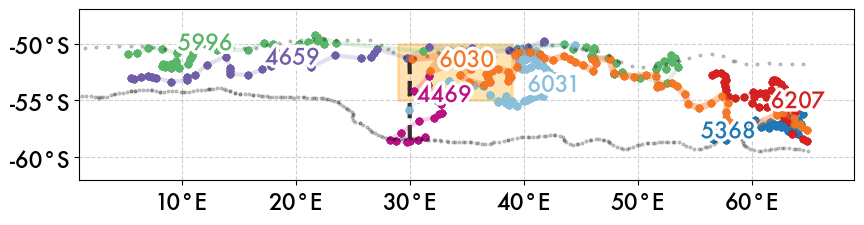

In [21]:
# Single plot for argo map
fig = plt.figure(figsize=(10,8))
ax=plt.gca()

for wmo in wmoids[wmoids!=5906030]:
    ax.plot(floatDF[floatDF.wmoid==wmo].lon,floatDF[floatDF.wmoid==wmo].lat,
            color = wmo_colors[wmo], alpha=0.2, linewidth=3, label=str(wmo)[3:], zorder=3)
    ax.scatter(floatDF[floatDF.wmoid==wmo].lon,floatDF[floatDF.wmoid==wmo].lat,
            color = wmo_colors[wmo], alpha=0.1, s=20, zorder=3)

for wmo in [5906030]:
    ax.plot(floatDF[floatDF.wmoid==wmo].lon,floatDF[floatDF.wmoid==wmo].lat,
            color = sns.color_palette("Oranges")[3], alpha=0.4, linewidth=5, label=str(wmo)[3:], zorder=3)
    ax.scatter(floatDF[floatDF.wmoid==wmo].lon,floatDF[floatDF.wmoid==wmo].lat,
            color = sns.color_palette("Oranges")[3], alpha=0.1, s=20, zorder=3)

for front in [SIF, PF]:
     front = front[(front.lon > 0 ) & (front.lon <65)]
     ax.scatter(front.lon, front.lat, color='k', alpha=0.2, s=4, zorder=3)
#      ax.plot(front.lon, front.lat, color='k', alpha=0.1, linewidth=2, zorder=3)

# plt.title('BGC-Argo Training Data')
# plt.title('Argo Yeardays: ' + str(start_yd) + ' to ' + str(end_yd))
rect = patch.Rectangle((29,-55),10,5, fill=True, color="orange", alpha=0.3,linewidth=2, zorder=1)

ax.add_patch(rect)
ax.set_xlim(1,69)
ax.set_ylim(-62,-47)
ax.set_aspect('equal')

ax.yaxis.set_major_formatter("{x:1.0f}°S")
ax.xaxis.set_major_formatter("{x:1.0f}°E")

ax.grid(linestyle='dashed', alpha=0.6, zorder=1)

lines = ax.get_lines()
labelLines(lines, align=False, fontsize=16, zorder=3)
# labelLines(lins) # , align=False, fontsize=18)
ax.plot(shipDF.lon, shipDF.lat, alpha=0.8, linestyle='dashed', c='k', linewidth=3)

# if save:
#         plt.savefig('../figures/Argo_simple_region_map.png', dpi=300)

In [288]:
# shipDF.to_csv('../data/go-ship/mldata_shipDF_qc.csv', index=False)
# argo_qc.to_csv('../data/bgc-argo/mldata_floatDF_qc.csv', index=False)

### 1.1.1 Checking Training Data Distributions

- We do quick screening to make sure the training data are representative. 

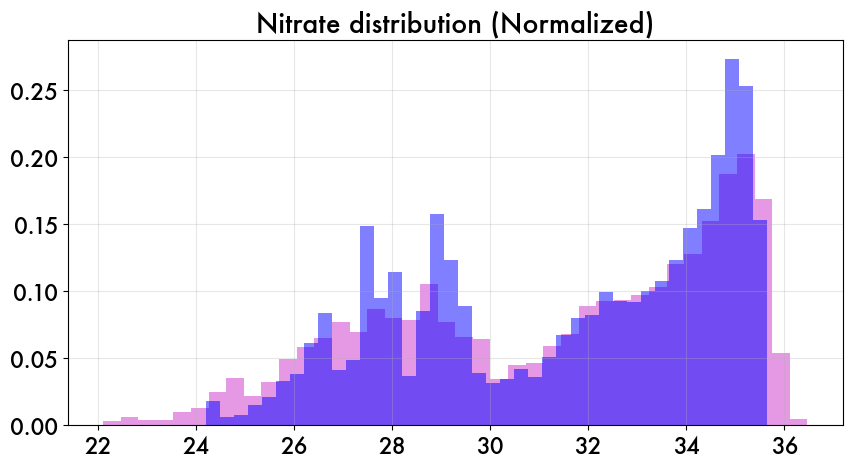

In [13]:
# Compare distributions between float and gliders
threshold = 1000
dfloat = floatDF[floatDF.pressure<threshold]

fig = plt.figure(figsize=(10,5))
plt.hist(dfloat.nitrate, bins=40, color='m', alpha=0.4, label="float", density=True)
plt.hist(dfloat[dfloat.wmoid == 5906030].nitrate, bins=40, color='b', alpha=0.5, label="float 6030", density=True)
plt.title('Nitrate distribution (Normalized)')
plt.grid(alpha=0.3, zorder=1)


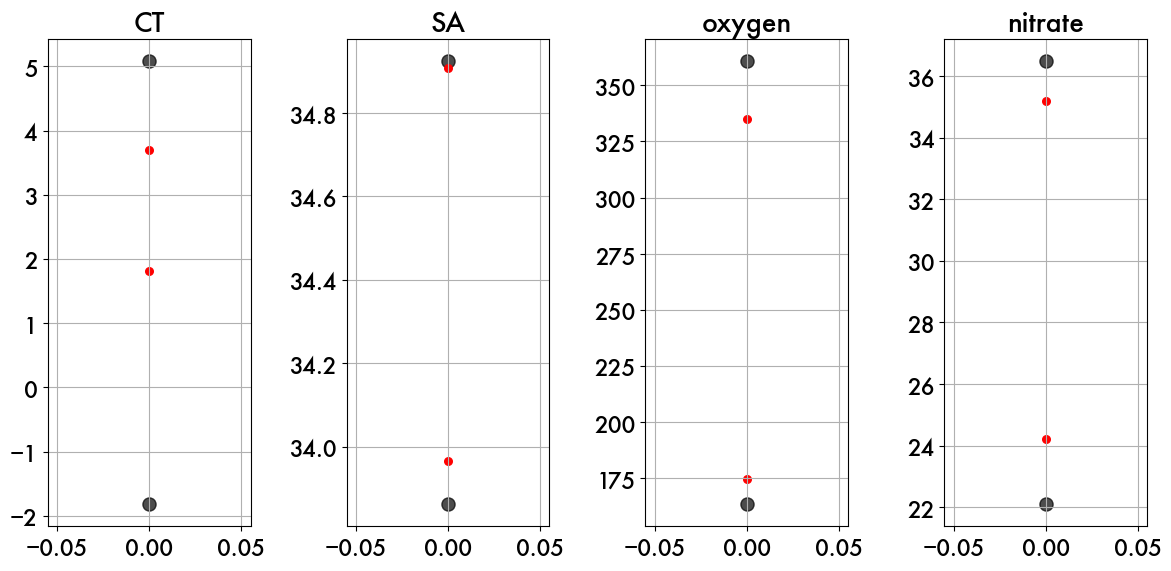

In [15]:
fig, axs = plt.subplots(1,4, figsize=(12,6), layout='tight')   
axs = axs.flatten()

others = floatDF[floatDF.wmoid!=5906030]
for i, var in enumerate(['CT' , 'SA', 'oxygen', 'nitrate']):
    minval = others[var].min()
    maxval = others[var].max()
    axs[i].scatter([0,0], [minval, maxval], c='k', alpha=0.7, s=90, label='others')
    axs[i].scatter([0,0], [sgfloat[var].min(), sgfloat[var].max()], c='r', s=30, label='sogos')
    # axs[i].scatter([0,0], [df_659[var].min(), df_659[var].max()], c='c', s=30, label='sg660')
    axs[i].set_title(var)
    axs[i].grid()


## 1.2 Setting up DataFrames with training variables

- Note that the DataFrame `sgfloat` contains observations from the SOGOS float WMO 5906030. 

# PART 2: Preparing ML Data for Training, Validation, Testing

- Prepare data for RF development by subsampling and scaling. 



For BGC-Argo and GO-SHIP data, only observations up to depths of 1000 m are used to match the vertical range of the gliders. Random subsets with ~80% and ~20% of this data are used for training and simple holdout validation, respectively. When data are split into these subsets, observations from each profile are always kept together rather than sampling point observations individually. With this subsampling approach, each RF regressor is trained or validated on data containing complete vertical profiles, such that information about the local vertical structure is preserved. The training dataset consists of 11645 observations, and the validation dataset has 2933 observations. The test dataset from the withheld SOGOS float (WMO:5906030) has 3308 observations, from 16 profiles. All features are standardized to have unit variance and zero mean before training. The parameters of the standard scaler are determined from the training data and applied to the validation and testing data.

number of profiles with no 10m data:  32
approx # of obs within profile that were averaged for final mlp:  2.967741935483871
number of nan mlds even where 10m exists:  6


profid     yearday     lat     lon         mld
0   5906030000  120.374294 -51.355  30.208         NaN
1   5906030001  125.159699 -51.074  32.828   90.886666
2   5906030003  135.173252 -52.452  31.764         NaN
3   5906030004  140.063449 -51.856  33.445   70.994286
4   5906030005  145.180833 -51.417  34.669         NaN
..         ...         ...     ...     ...         ...
58  5906030059  650.545949 -57.037  63.757  186.150000
59  5906030060  660.873565 -57.064  64.008         NaN
60  5906030061  671.160359 -57.102  64.260  186.864995
61  5906030062  681.567778 -57.315  64.442  186.270000
62  5906030063  691.905764 -57.596  64.892         NaN

[63 rows x 5 columns]

In [16]:
# If rerunning, 
floatDF = pd.read_csv('../data/bgc-argo/mldata_floatDF_qc.csv')
shipDF = pd.read_csv('../data/go-ship/mldata_shipDF_qc.csv')

In [33]:
# Add last variables and set up final training data

# Add seasonal variable
def add_yd_sinusoids(DF):
    DF['ydcos'] = [sg.get_ydsines(x)[0] for x in DF.yearday.values]
    DF['ydsin'] = [sg.get_ydsines(x)[1] for x in DF.yearday.values]
    return DF

floatDF = add_yd_sinusoids(floatDF)
shipDF = add_yd_sinusoids(shipDF)

# Choose final features to be tested
tvars = ['yearday','lat','lon','pressure','CT', 'SA','oxygen', 'sigma0', 'log_buoyancy', 
         'spice','o2sat', 'ydcos', 'ydsin']
pvars = ['nitrate']  # prediction variable

# Take variables of interest
floatDF = floatDF[tvars + pvars + ['wmoid', 'profid', 'dist_maxb']].dropna()
shipDF = shipDF[tvars + pvars + ['profid', 'dist_maxb']].dropna() # dont drop on wmoid yet

print('# Ship observations (without NaNs): \t', shipDF.shape[0])
print('# Float observations (without NaNs ): \t', floatDF.shape[0])
print('# 5906030 observations (without NaNs): \t', floatDF[floatDF.wmoid==5906030].shape[0])

# Ship observations (without NaNs): 	 242
# Float observations (without NaNs ): 	 17644
# 5906030 observations (without NaNs): 	 3308


## 2.1 Subsample data into training, validation, and test sets

In [34]:
# Split float and ship profiles separately. 

# Note that observations from vertical profiles are always kept together,
# since the goal oftraining is to predict vertical structure of the water column. 
[training_float, validation_float, empty] = crf.split_profiles(floatDF[floatDF.wmoid!=5906030], test_split = False)
[training_ship, validation_ship, empty] = crf.split_ship(shipDF, test_split = False)

training = pd.concat([training_float, training_ship], ignore_index=True)
validation = pd.concat([validation_float, validation_ship], ignore_index=True)
test = floatDF[floatDF.wmoid==5906030] # set SOGOS 

print('Subsampled Datasets: ')
# print('wmoids: ' + str(wmoids))
print('# training observations: \t' + str(len(training)))
print('# validation observations: \t' + str(len(validation)))
print('# test observations: \t\t' + str(len(test)))

Subsampled Datasets: 
# training observations: 	11645
# validation observations: 	2933
# test observations: 		3308


In [35]:
floatDF

yearday     lat     lon    pressure        CT         SA     oxygen  \
0     -603.853947 -54.200  30.351   17.540000  1.855033  34.127808  326.22037   
1     -603.853947 -54.200  30.351   22.119999  1.854044  34.127803  326.00485   
2     -603.853947 -54.200  30.351   31.470000  1.854344  34.127822  325.97280   
3     -603.853947 -54.200  30.351   33.329998  1.854252  34.127827  325.43460   
4     -603.853947 -54.200  30.351   45.660000  1.853641  34.127389  325.75323   
...           ...     ...     ...         ...       ...        ...        ...   
17639  873.260116 -58.399  64.473  752.199950  2.255729  34.794035  168.82108   
17640  873.260116 -58.399  64.473  802.300000  2.229490  34.816213  170.83778   
17641  873.260116 -58.399  64.473  852.519960  2.221816  34.834315  173.21684   
17642  873.260116 -58.399  64.473  902.430000  2.210376  34.844450  175.28784   
17643  873.260116 -58.399  64.473  952.459960  2.190991  34.858587  177.66635   

          sigma0  log_buoyancy     spice       o2sat     ydcos     ydsin  \
0      27.156729    -17.809540 -0.588239  334.490032 -0.565227  0.824936   
1      27.156800    -15.948689 -0.588326  334.498369 -0.565227  0.824936   
2      27.156792    -17.868096 -0.588287  334.495852 -0.565227  0.824936   
3      27.156803    -16.507311 -0.588292  334.496628 -0.565227  0.824936   
4      27.156500    -14.547730 -0.588650  334.503079 -0.565227  0.824936   
...          ...           ...       ...         ...       ...       ...   
17639  27.655533    -12.344364 -0.085047  329.440124 -0.780405  0.625275   
17640  27.675346    -12.584686 -0.071876  329.598916 -0.780405  0.625275   
17641  27.690382    -13.025102 -0.059860  329.615605 -0.780405  0.625275   
17642  27.699389    -13.147500 -0.053789  329.683776 -0.780405  0.625275   
17643  27.712231    -13.147500 -0.045632  329.807073 -0.780405  0.625275   

         nitrate    wmoid      profid   dist_maxb  
0      27.304010  5904469  5904469085   94.469995  
1      27.261232  5904469  5904469085   89.889996  
2      27.312778  5904469  5904469085   80.539995  
3      27.344120  5904469  5904469085   78.679997  
4      27.111767  5904469  5904469085   66.349995  
...          ...      ...         ...         ...  
17639  33.561770  5906207  5906207048 -560.069950  
17640  33.317307  5906207  5906207048 -610.170000  
17641  32.770493  5906207  5906207048 -660.389960  
17642  32.454758  5906207  5906207048 -710.300000  
17643  31.869192  5906207  5906207048 -760.329960  

[17644 rows x 17 columns]

Comment on notation: 

We use `training` for unscaled and `training_scaled` for scaled observations.

# PART 3: Training Random Forest / Feature Selection

## 3.1 Set up variable feature lists.

During training, we provide each version of the RF model with different ``feature lists", which are subsets of the available ocean parameters that can be used for training. Features such as conservative temperature (CT), absolute salinity (SA), potential density ($\sigma_0$), spice ($\tau$), Brunt-Vaisala buoyancy frequency ($N^2$), dissolved oxygen (O${_2}$), oxygen saturation, as well as coordinate features such as latitude (lat), longitude (lon), time, and season ($sz_1$ and $sz_2$) were considered. Spice is a measure of temperature and salinity variations, and acts as a tracer of water masses in the interior ocean. Of the models considered, results from a selection of seven models with increasing complexity are presented

In [22]:
# 3.3.1 Initialize variables to train the different models on 

var_list = {
            'Model_A': ['spice', 'sigma0'],
            'Model_B': ['CT', 'SA', 'pressure'], 
            'Model_C': ["CT", "SA", "pressure", 'oxygen'],
            'Model_D': ["CT", "SA", "pressure", "oxygen", 'lat', 'lon', 'yearday'],
            'Model_E': ["CT", "SA", 'pressure', 'oxygen', 'lat', 'lon', 'yearday', 'o2sat'],
            'Model_F': ["CT", "SA", 'pressure', 'oxygen', 'lat', 'lon', 'yearday', 'log_buoyancy'],
            'Model_G': ["CT", "SA", 'pressure', 'oxygen', 'lat', 'lon', 'yearday', 'ydcos', 'ydsin']
            }

model_list = list(var_list.keys())

# Create dictionary of features
allvars = []
for k in var_list.keys():
    allvars = allvars + var_list[str(k)]
allvars = pd.unique(allvars)

In [22]:
# Make Model palettes (mod April 2024)
model_palettes = {'columns':model_list}
model_palettes['Model_A'] = sns.color_palette('Purples')[3] #change for figures
model_palettes['Model_B'] = sns.color_palette('Reds')[4]
model_palettes['Model_C'] = sns.color_palette('Set2')[4]
 
model_palettes['Model_D'] = sns.color_palette('Blues')[4]
model_palettes['Model_E'] = sns.color_palette('Set2')[1] 
model_palettes['Model_F'] = sns.color_palette('Set2')[0]
model_palettes['Model_G'] = sns.color_palette('RdPu')[5]

## 3.2 Main Training Method

- Demonstrate Random Forest development using scikit-learn

Here, we demonstrate the method by which we train our RF model. 

Each RF regressor is constructed using the scikit-learn Python package with $n=1000$ trees, which is sufficiently large to constrain the estimates but computationally inexpensive. A maximum of 1/3 of total features were considered at each node \citep{james2013_Introduction}, with a minimum node sample size of 5 for a split to be considered. 

In [17]:
# Method: Training the RF model. 

var_predict = 'nitrate'
def train_RF(var_list, training, validation, test, ntrees=1000, max_feats = 1/3, scaler='StandardScaler', min_samples_split=5):
    """ 
    Main method to train the RF model.
    Update 04.18: Add back bootstrapping. 
    @param: 
        var_list: list of variables to use in the model
        training: training data unscaled, i.e. original range of values
        validation: validation data unscaled
        test: test data unscaled 
        ntrees: 1000 trees by default.

    @return:
        Mdl: trained RF model
        Mdl_MAE: Rescaled mean absolute error for training, validation, and test sets
        Mdl_IQR: Rescaled IQR for training, validation, and test sets
        DF_with_error: Rescaled dataframe with error metrics for the *TEST* set

    """

    Mdl = RandomForestRegressor(ntrees, max_features = max_feats, random_state = 0, bootstrap=True, min_samples_split=min_samples_split)
        #  max_features: use at most X features at each split (m~sqrt(total features)). ISSR.

    # Drop NaN's without profid or wmoid
    cols_na = [col for col in training.columns if col not in ['profid', 'wmoid', 'AOU', 'dist_maxb']]
    training_nona = training.dropna(axis=0, subset=cols_na)  # makes same length as training_scaled
    validation_nona = validation.dropna(axis=0, subset=cols_na)
    test_nona = test.dropna(axis=0, subset=cols_na)

    # Scale features using the specified 'type' for each subset of data
    # Method drops Nan's internally. 
    # Note that scaler will NOT scale the target variable nitrate.
    # [training_scaled, validation_scaled, test_scaled] = scale_down_tvt(training_nona, validation_nona, test_nona, type=scaler)

    # Create X Variables for each subset of data. Scale down. 
    X_training = training_nona[var_list].to_numpy()
    X_validation = validation_nona[var_list].to_numpy()
    X_test = test_nona[var_list].to_numpy()

    # Nitrate, the target variable. 
    Y_training = training_nona[var_predict].to_numpy()
    Y_validation = validation_nona[var_predict].to_numpy()
    Y_test = test_nona[var_predict].to_numpy()

    # Train the model
    Mdl.fit(X_training, Y_training)

    # Estimate
    Y_pred_training = Mdl.predict(X_training)
    Y_pred_validation = Mdl.predict(X_validation)
    Y_pred_test = Mdl.predict(X_test)

    # Create dataframe for the test set with depth --> 
    DF_with_error = test_nona.copy(); 
    DF_with_error = DF_with_error.reset_index(drop=True)
    observed_nitrate = DF_with_error[var_predict].to_numpy()

    # Save new dataframe with test results
    DF_with_error['test_prediction'] = Y_pred_test
    DF_with_error['test_error'] = DF_with_error['test_prediction'] - observed_nitrate
    DF_with_error['test_relative_error'] = DF_with_error['test_error']/observed_nitrate

    # Error metrics
    AE_RF_training = np.abs(Y_pred_training - training_nona[var_predict])
    IQR_RF_training = iqr(abs(AE_RF_training))
    r2_RF_training = r2_score(training_nona[var_predict], Y_pred_training)

    # Return validation metrics
    AE_RF_validation = np.abs(Y_pred_validation - validation_nona[var_predict])
    IQR_RF_validation = iqr(abs(AE_RF_validation))
    r2_RF_validation = r2_score(validation_nona[var_predict], Y_pred_validation)

    validation_error = validation_nona.copy() #pd.DataFrame()
    validation_error['val_error'] = Y_pred_validation - validation_nona[var_predict]
    validation_error['val_relative_error'] = validation_error['val_error']/validation_nona[var_predict]

    AE_RF_test = np.abs(Y_pred_test - test_nona[var_predict]) # same as DF_with_error['test_error']
    IQR_RF_test = iqr(abs(AE_RF_test))
    r2_RF_test = r2_score(test_nona[var_predict], Y_pred_test)

    Mdl_MAE = [np.nanmedian(abs(AE_RF_training)), np.nanmedian(abs(AE_RF_validation)), np.nanmedian(abs(AE_RF_test))]
    Mdl_IQR = [IQR_RF_training, IQR_RF_validation, IQR_RF_test]
    Mdl_r2 = [r2_RF_training, r2_RF_validation, r2_RF_test]

    return [Mdl, Mdl_MAE, Mdl_IQR, Mdl_r2, DF_with_error, validation_error]


## 3.3 Running RF Model Versions

In [218]:
import class_RF as crf # class for RF model


In [219]:
# Train the models with chosen feature lists and hyperparameters.
# We will construct a custom class object, ModelVersion, to store all the models and their results.
# Using the function ModelVersion.get_metrics() will return validation and test errors.
ntrees = 1000
max_feats = 1/3
min_samples_split = 5
desc = 'full'
description = 'Hyperparameters: trees=' + str(ntrees) + ', max_features=' + str(max_feats)

print(description + '\n')

# Create the RF
RF_full = crf.ModelVersion(ind_list = model_list)
# run_list = model_list # ['Model_A', 'Model_B', 'Model_C'] # change here if you only want to run a few.

for k in tqdm(model_list): 
    [RF_full.models[k], RF_full.MAE[k], RF_full.IQR[k], 
     RF_full.r2[k], RF_full.DF_err[k], 
     RF_full.val_err[k]] = train_RF(var_list[k], 
                            training, validation, test, 
                            ntrees = ntrees, max_feats = max_feats,
                            min_samples_split=min_samples_split)
    
# To add another model to an existing ModelVersion
# RF_full.add('Model_K') 

Hyperparameters: trees=1000, max_features=0.3333333333333333



100%|██████████| 7/7 [01:24<00:00, 12.14s/it]


In [24]:
desc = 'full'

In [25]:
# To save the test prediction values for the SOGOS float , can run below, changing save to True.
# save = False
# if save:
#     mlpreds = test.copy()
#     for k in ['Model_A', 'Model_B', 'Model_C', 'Model_D', 'Model_E', 'Model_F', 'Model_G']:
#         temp = RF_full.DF_err[k]['test_prediction'].values
#         mlpreds[k] = temp

#     mlpreds.describe()
#     mlpreds.to_csv('../working-vars/RF-training/mlresult_sgfloat_allpreds_' + desc +'.csv')

In [151]:
# To save the actual datasets containing the simple validation and test errors for the model 
save = False
if save:
    dir = '../working-vars/RF-training/'

    for mdl in model_list:
        RF_full.DF_err[mdl].to_csv(dir + 'mlresult_test_err_' + mdl[-1] + '_' + desc +'.csv')
        RF_full.val_err[mdl].to_csv(dir + 'mlresult_val_err_' + mdl[-1] + '_' + desc +'.csv')


## 3.4 Make error dictionaries

- Functions for organizing errors are found in `class_RF.py`

In [217]:
importlib.reload(crf)

<module 'class_RF' from '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/RandomForest_SG/scripts/class_RF.py'>

In [236]:
model_metrics

validation_MAE  validation_IQR  validation_r2  test_MAE  test_IQR  \
ind                                                                          
Model_A        0.308932        0.460559       0.968101  0.287230  0.354051   
Model_B        0.266964        0.368643       0.979110  0.276422  0.340870   
Model_C        0.243118        0.353381       0.984171  0.242266  0.338609   
Model_D        0.145554        0.210631       0.993101  0.225964  0.329500   
Model_E        0.145935        0.214053       0.993127  0.221593  0.326651   
Model_F        0.152587        0.224587       0.992676  0.222030  0.325228   
Model_G        0.142264        0.204743       0.993179  0.203412  0.289696   

          test_r2  
ind                
Model_A  0.974752  
Model_B  0.978878  
Model_C  0.977659  
Model_D  0.984433  
Model_E  0.984855  
Model_F  0.984731  
Model_G  0.987127

In [404]:
importlib.reload(crf)

<module 'class_RF' from '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/RandomForest_SG/scripts/class_RF.py'>

In [407]:
# Save and print validation error metrics for a particular model
model_metrics = RF_full.get_metrics() 
crf.print_errors(RF_full.val_err['Model_G'], var ='val_error', pres_lim= [0,1000]); print()
# crf.print_errors(RF_full.DF_err['Model_G'], var ='test_error', pres_lim= [0,1000])

# To save:
save=False
if save:
    model_metrics.to_csv('../working-vars/RF-training/mlresult_model_metrics_' + desc + '.csv')

Error metric: val_error
Restricted to depths 0 to 1000:
median abs error: 	0.14226420967661824
mean abs error 		0.20584452441725407

95% of errors fall between:
-0.58111 to 0.59002

During SOGOS between depths 0 to 1000:
95% of errors fall between:
-0.65372 to 0.63259

Error metric: test_error
Restricted to depths 0 to 1000:
median abs error: 	0.20341177371638608
mean abs error 		0.267359791753317

95% of errors fall between:
-0.6072 to 0.77137

During SOGOS between depths 0 to 1000:
95% of errors fall between:
-0.6478 to 1.05943


In [ ]:
# To get back to results from here: 
# RF_ver = ModelVersion(model_list)

# list = []
# for mod in model_list:
#     list.append(pd.read_csv('../working-vars/RF-training/mlresult_' + mod + '_val_error'))
# dict_valerr = {k:v for k, v in zip(model_list, values)}
# RF_ver.val_err = dict_valerr

# list = []
# for mod in model_list:
#     list.append(pd.read_csv('../working-vars/RF-training/mlresult_' + mod + '_test_error'))
# dict_testerr = {k:v for k, v in zip(model_list, values)}
# RF_ver.DF_err = dict_testerr

# PART 4: Feature Importances

- Selecting best feature list for the Random Forest regressor

A **feature list** is the set of predictive variables given as inputs to the RF regressor; the values of these features are used to determine node conditions for each decision tree. Variables in a feature list can include observed parameters like pressure and $O_2$, or calculated parameters like buoyancy. 

A unique aspect of RF is that it returns a measure of **feature importance**, which reflects the predictive capability of on a given feature. The higher the feature importance, the greater reduction in target variable variance. A range of example models and their respective feature importances are shown below. We discuss why screening of validation errors is necessary for selecting a final feature list. 

## 4.0 Calculate Feature Importance Dictionary

In [28]:
# Palette for plotting feature importance comparisons
pal = sns.color_palette('Set3', n_colors = 9)
dict = {'spice' : pal[2],
        'sigma0' : pal[3],
        'lat' : pal[0],
        'lon' : pal[8],
        # 'yearday' : pal[1],
        'oxygen' : pal[5],
        'CT' : pal[6],
        'SA' : pal[7],
        'pressure' : pal[4]}
        
pal = sns.color_palette('Set1', n_colors = 48)
pald = {k:v for k, v in zip(model_list, pal)}

In [29]:
# Make total feature importance dictionary for plotting
# dict = dict.fromkeys(allvars)
feat_imps = pd.DataFrame()

# Fill in feature importance
for ind, vkey in enumerate(model_list):
    for var in var_list[vkey]:
        feat_imps.at[ind, var] = RF_full.models[vkey].feature_importances_[var_list[vkey].index(var)]

feat_imps['Mdl'] = model_list
feat_imps = feat_imps.set_index('Mdl').fillna(np.nan)
feat_imps

# To save feature importance dataframe: 
save=False
if save:
    feat_imps.to_csv('../working-vars/RF-training/mlresult_feat_imps_' + desc +'.csv')

## 4.1 Feature Importance Plots

### Figure: Feature Importance Plot

Whereas the temporal and spatial features (latitude, longitude, and yearday) appear to have low feature importance, we find that their inclusion in the model reduces bias in the estimates and generally improves model performance as seen during model validation (Section 5). Our results suggest that feature importance alone cannot be used to determine final feature selection, and validation error distributions should be screened during training. An interpretation is that feature importance is biased towards the variable that reduces bin variance most at the first split; a predictor like latitude may help fine-tune the output, although it is a weak first-order predictor for nitrate concentration. 

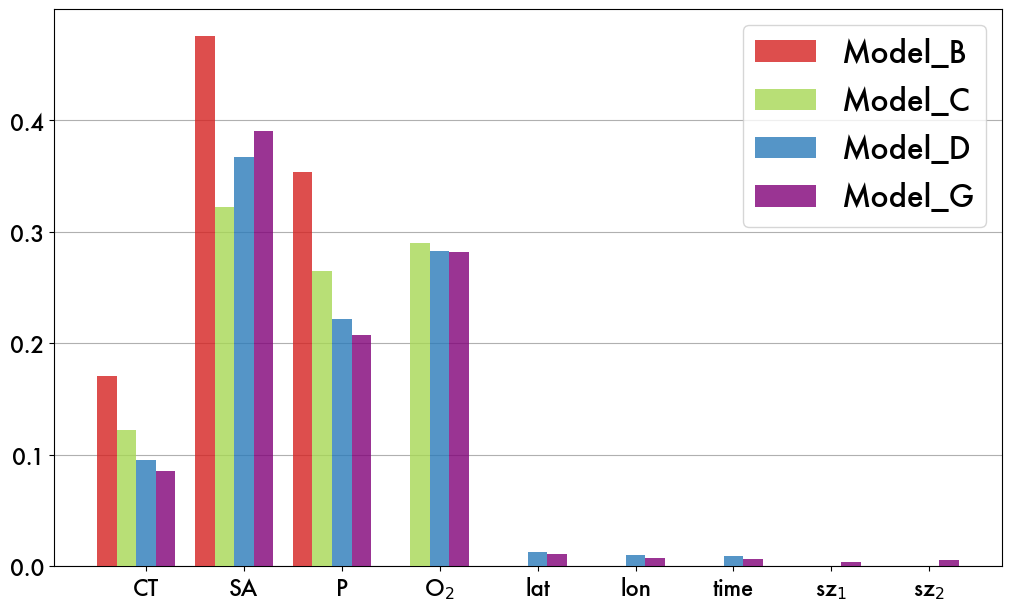

In [25]:
# Make side by side comparisons between model (grouped by variable)

fig = plt.figure(figsize=(10,6), layout='constrained')
ax = fig.gca()
barwidth=.8

# To compare models B, C, D, and G:
modlist = ['Model_B', 'Model_C', 'Model_D', 'Model_G']
varslist = ['CT', 'SA', 'pressure', 'oxygen', 'lat', 'lon', 'yearday','ydcos', 'ydsin']
xlabel = ['CT', 'SA', 'P', 'O$_2$', 'lat', 'lon', 'time', 'sz$_{1}$', 'sz$_{2}$']

# To plot the simple models A through D
# modlist = model_list[:4]
# varslist = allvars[:-4]
# xlabel = ['spice', 'sigma0', 'CT', 'SA', 'pressure', 'oxygen', 'lat', 'lon', 'yearday']

# To plot the complex models D through G
# modlist = model_list[3:]
# varslist = allvars[2:]
# xlabel = ['CT', 'SA', 'pressure', 'oxygen', 'lat', 'lon', 'yearday',
#                     'o2sat','log(N2)', 'sz1', 'sz2']

# Result of plot method
xind = dict.fromkeys(modlist)
xind[modlist[0]] = np.arange(len(varslist))*len(modlist)

for i in range(len(modlist)-1):
    xind[modlist[i+1]] = [x + barwidth for x in xind[modlist[i]]]

for modtag in modlist:
    ax.bar(xind[modtag], feat_imps[varslist].loc[modtag].to_numpy(), color = model_palettes[modtag], alpha=0.8, label = modtag, zorder=3)

ax.grid(axis='y', zorder=0)
ax.legend(loc='upper right', fontsize=22)
ax.set_xticks(xind[modlist[2]]);
ax.set_xticklabels(varslist);
ax.set_xticklabels(xlabel);


# PART 5: RF Validation

To select our final feature list, we screen the validation errors for each model version using the withheld validation dataset.

## 5.1 "Simple" 20% Holdout Validation

- Here, we demonstrate how a typical 
- Distribution plots are errors based on the 20% validation data
- Therefore, only 20% of the data are represented here. In the next Cross-Validation step, we will use a slightly different method where all data can be represented in the validation scheme.

We plot the Gaussian kernel density estimate (KDE) for validation errors from each model A-G. The probability density is most closely centered around 0 for model G. Note similarities between models D-G, which are shown more clearly in the second figure. 

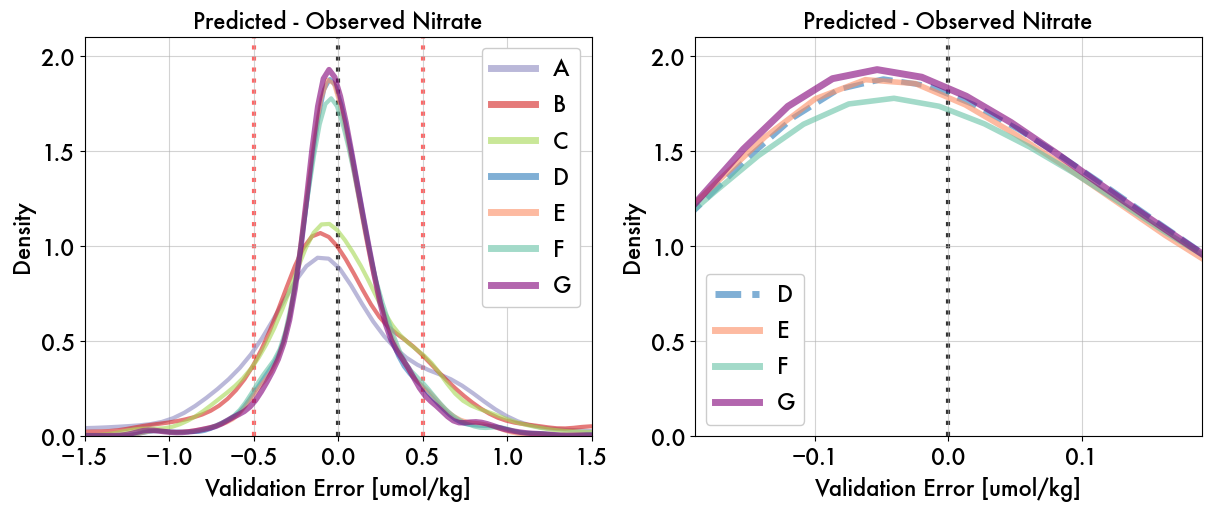

In [32]:
# Type 1: Plot Simple Validation Errors

tag = 'Predicted - Observed Nitrate'
# var = 'val_relative_error'; ymax=70
var = 'val_error'; ymax=2.1
dat = RF_full.val_err

# Make Figure with 2 Subplots
fig, axs = plt.subplots(1, 2, figsize=(12,5), layout='constrained')
axs=axs.flatten()

for ax in axs[0:1]:
    for mod in model_list[:]: 
        RF = dat[mod][var]

        # Add Gaussian KDE to estimate probability density function
        x = np.linspace(*RF.agg([min, max]), 100)
        kde = scipy.stats.gaussian_kde(RF)

        lw = 3; ls = 'solid'
        if mod == 'Model_G':
            lw=lw+1
        ax.plot(x, kde(x), color=model_palettes[mod], linewidth=lw, linestyle=ls, label=mod[-1], alpha=0.6)

    if var == 'val_error':
        ax.set_xlim([-1.5, 1.5])

    leg = ax.legend(fontsize=16, framealpha=1)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5)

for ax in axs[1:]:
    for mod in model_list[3:]: # ['Model_A', 'Model_G']: #
        RF = dat[mod][var]

        # Gaussian KDE
        x = np.linspace(*RF.agg([min, max]), 100)
        kde = scipy.stats.gaussian_kde(RF)

        lw = 4; ls = 'solid'
        if mod == 'Model_G':
            lw=lw+1
        if mod in ['Model_D']:
            ls = '--'
        plt.plot(x, kde(x), color=model_palettes[mod], linewidth=lw, linestyle = ls, label=mod[-1], alpha=0.6)

    ax.set_xlim([-.19, .19])
    ax.set_ylim([1.48, 2.02])

    # Legend
    leg = plt.legend(fontsize=16, framealpha=1)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5)
    
for ax in axs:
    # Show float uncertainty and 0 line
    ax.axvline(x=0.5, color='r', linestyle='dotted', linewidth=3, alpha=0.6, zorder=0)
    ax.axvline(x=-0.5, color='r', linestyle='dotted', linewidth=3, alpha=0.6, zorder=0)
    ax.vlines(0, ymin=0, ymax=ymax, colors='k', alpha=0.8, linewidth=3, linestyle='dotted', zorder=1)
    ax.set_ylim([0,ymax])
    ax.grid(alpha=0.55, zorder=1)

    ax.set_ylabel('Density')
    ax.set_xlabel('Validation Error [umol/kg]')
    ax.set_title(tag, fontsize=16)




Based on the distribution of validation errors, models D, E, and G have the best performance. If two models perform similarly, the one with fewer training variables is preferred to minimize overfitting, so the final model is chosen between D and G. The difference between these two versions is that model G includes additional seasonal variables as in Sharp et al. 2022. Since the seasonal component tends to improve estimates especially near the surface, we report the following cross-validation results for model G.

# PART 6: Cross Validation: K-Fold

One complication of applying RF to in-situ observations from autonomous profilers is that the training data are biased in space and time. As such, the training data are not perfectly representative of the regional dynamics and may cause overfitting during model development (Stock et al. 2022). We therefore use two other cross-validation metrics, k-fold and spatial leave-one-out, to assess the applicability of the chosen model.

In k-fold validation, the entire training dataset is split into random subsets of roughly equal size, called **folds**. We split the training data into k=10 folds, which was chosen to leave approximately 1000 point observations in each subset. Each fold is withheld as the validation set once while the model is trained on the other nine folds, such that there are 10 total iterations of the model. See Stock et al. (2022) for more details. 

## 6.1 Single K-Fold Example

In [33]:
importlib.reload(crf)

<module 'class_RF' from '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/RandomForest_SG/scripts/class_RF.py'>

In [213]:
# Split data into k=10 folds using methods 
# Exclude the SOGOS float values (reserved for Testing) 
fold_input = pd.concat([shipDF, floatDF])
fold_input = fold_input[fold_input.wmoid!=5906030]
ftrain, fvalidation = crf.split_kfolds(fold_input, nfolds=10)

In [226]:
ftrain[4].shape

(13048, 17)

In [214]:
# EXAMPLE ONLY: One Model Run
# Demonstrating how the KFold object works. 
# In the next step, the KFold acts as an intermediate step before
# constructing the full CrossVal_KFold object. 

# Train over the k=10 folds, withholding each one for validation. 
# Set hyperparameters
kfold_mdl = 'Model_G'
nfolds = 10
description = 'ntrees=' + str(ntrees) + ', max_features=' + str(max_feats)
print('Training RF k-folds: ' + description)
print('Model: ' + kfold_mdl)

# Create the KFold object
kfold_mdlX = crf.ModelVersion(ind_list=np.arange(1,nfolds+1))

# Run the model 
for k in tqdm(kfold_mdlX.model_list): 
    [kfold_mdlX.models[k], kfold_mdlX.MAE[k], kfold_mdlX.IQR[k], 
     kfold_mdlX.r2[k], kfold_mdlX.DF_err[k], 
     kfold_mdlX.val_err[k]] = train_RF(var_list[kfold_mdl], ftrain[k], fvalidation[k], test, 
                                     ntrees = ntrees, max_feats = max_feats,
                                     min_samples_split= min_samples_split)

fold_metrics = kfold_mdlX.get_metrics()
fold_metrics

Training RF k-folds: ntrees=1000, max_features=0.3333333333333333
Model: Model_G


100%|██████████| 10/10 [03:06<00:00, 18.67s/it]


validation_MAE  validation_IQR  validation_r2  test_MAE  test_IQR  \
model                                                                      
1            0.160173        0.220688       0.991378  0.207104  0.302104   
2            0.148248        0.203800       0.994201  0.206662  0.298763   
3            0.155583        0.258854       0.991692  0.209823  0.302636   
4            0.137316        0.208766       0.991394  0.204723  0.299003   
5            0.113674        0.156309       0.994475  0.208952  0.298746   
6            0.150417        0.208136       0.994658  0.207012  0.307508   
7            0.140189        0.202756       0.992785  0.208527  0.313570   
8            0.136550        0.208998       0.993369  0.207353  0.306314   
9            0.137360        0.213398       0.992641  0.210693  0.303619   
10           0.127484        0.180321       0.993604  0.202908  0.293807   

        test_r2  
model            
1      0.986178  
2      0.986304  
3      0.986084  
4      0.986347  
5      0.986319  
6      0.985983  
7      0.985845  
8      0.986321  
9      0.985810  
10     0.986234

In [35]:
# EXAMPLE ONLY: One Model Run
# Demonstrating how the KFold object works. 
# In the next step, the KFold acts as an intermediate step before
# constructing the full CrossVal_KFold object. 

# Train over the k=10 folds, withholding each one for validation. 
# Set hyperparameters
kfold_mdl = 'Model_G'
description = 'ntrees=' + str(ntrees) + ', max_features=' + str(max_feats)
print('Training RF k-folds: ' + description)
print('Model: ' + kfold_mdl)

# Create the KFold object
CV_kfold = crf.KFold(nfolds=10)

# Run the model 
for k in tqdm(CV_kfold.fold_list): 
    [CV_kfold.folds[k], CV_kfold.MAE[k], CV_kfold.IQR[k], 
     CV_kfold.r2[k], CV_kfold.DF_err[k], 
     CV_kfold.val_err[k]] = train_RF(var_list[kfold_mdl], ftrain[k], fvalidation[k], test, 
                                     ntrees = ntrees, max_feats = max_feats,
                                     min_samples_split= min_samples_split)

fold_metrics = kfold_mdlX.get_metrics()


Training RF k-folds: ntrees=1000, max_features=0.3333333333333333
Model: Model_G


  0%|          | 0/10 [00:02<?, ?it/s]


KeyboardInterrupt: 

## 6.2 Comprehensive K-Fold Cross-Validation
- cv_kfold['Mdl_G'] is the same as KFOLD above. 

In [43]:
# To re-run from existing files, if you've already run this step.:
# Warning: do not delete previous runs!

desc = 'full' # which run to retrieve
rerun = True
if rerun:
    model_list = ['Model_A', 'Model_B', 'Model_C', 'Model_D', 'Model_E', 'Model_F', 'Model_G']

    # Initialize object again
    cv_kfold = crf.CrossVal_KFold(model_list)

    for mdl in model_list: 
        df = pd.read_csv('../working-vars/RF-crossval/kfold_valDF_' + mdl + '_' + desc + '.csv')
        crossfold_MAEs = pd.read_csv('../working-vars/RF-crossval/kfold_list_MAEs_' + desc + '.csv')

        # Here's where we use the imported data 
        cv_kfold.val_DF[mdl] = df.copy()

        # Later, we will use the cv_kfold.val_error['Mdl_G'] to plot the histogram of full errors
        cv_kfold.val_error[mdl] = cv_kfold.val_DF[mdl]['val_error'] #allfold_val_df['val_error'] 
        cv_kfold.val_relative_error[mdl] = cv_kfold.val_DF[mdl]['val_relative_error']

        # We use the next imported data, MAE lists across models, 
        cv_kfold.MAEs[mdl] = crossfold_MAEs[mdl] # this is a list of 10 MAEs
                                                # mean of this is the final validation error for Model_X
        cv_kfold.IQRs[mdl] = crossfold_MAEs[mdl]


- If this is the first time running, use the cell block below

In [227]:
# For each model, find the validation errors for each fold

# If you want to add a model but not start over, comment out the below line:
cv_kfold = crf.CrossVal_KFold(model_list) # By model, hold a DataFrame with the validation errors. 

for mdl in tqdm(['Model_A']): #e.g. Model_G
    print('Running folds for ' + mdl) # which model to use for k-folding.
    
    # Here, by fold (individual KFold model for each Model_X)
    # Each KFold object then goes into the CrossVal_KFold object. 
    # Create the KFold object
    kfold_mdlX = crf.ModelVersion(ind_list=np.arange(1,nfolds+1))

    # Run the model 
    for k in tqdm(kfold_mdlX.ind_list): 
        [kfold_mdlX.models[k], kfold_mdlX.MAE[k], kfold_mdlX.IQR[k], 
        kfold_mdlX.r2[k], kfold_mdlX.DF_err[k], 
        kfold_mdlX.val_err[k]] = train_RF(var_list[mdl], ftrain[k], fvalidation[k], test, 
                                        ntrees = ntrees, max_feats = max_feats,
                                        min_samples_split= min_samples_split)
        
        # These are going to be all the validation errors from all folds, for histograms
        allfold_val_df = pd.DataFrame()
        for k in kfold_mdlX.ind_list:
            # Start combining all the rows from all folds
            allfold_val_df = pd.concat([allfold_val_df, kfold_mdlX.val_err[k]])
    
    # Here, by model. 
    # Fill in the full dataset, combined from all folds
    cv_kfold.val_DF[mdl] = allfold_val_df.copy()

    # Later, we will use the cv_kfold.val_error['Mdl_G'] to plot the histogram of full errors
    cv_kfold.val_error[mdl] = cv_kfold.DF[mdl]['val_error'] #allfold_val_df['val_error'] 
    cv_kfold.val_relative_error[mdl] = cv_kfold.DF[mdl]['val_relative_error']

    #These will be for  Table 1 
    fold_metrics = kfold_mdlX.get_metrics()
    cv_kfold.MAEs[mdl] = fold_metrics['validation_MAE'] # this is a list of 10 MAEs
                                                        # mean of this is the final validation error for Model_X
    cv_kfold.IQRs[mdl] = fold_metrics['validation_IQR']


# Dataframe from which we can make a boxplot of across-fold errors for each model
kfold_list_MAEs = pd.DataFrame.from_dict(cv_kfold.MAEs)




  0%|          | 0/1 [00:00<?, ?it/s]

Running folds for Model_A


100%|██████████| 1/1 [01:45<00:00, 105.52s/it]


In [ ]:
# validation_error['val_error'] = Y_pred_validation - validation_nona[var_predict]
#     validation_error['val_relative_error'] = validation_error['val_error']/validation_nona[var_predict]

#     AE_RF_test = np.abs(Y_pred_test - test_nona[var_predict]) # same as DF_with_error['test_error']
#     IQR_RF_test = iqr(abs(AE_RF_test))
#     r2_RF_test = r2_score(test_nona[var_predict], Y_pred_test)

#     Mdl_MAE = [np.nanmedian(abs(AE_RF_training))

In [228]:
cvk_metrics = cv_kfold.get_metrics() # check later
cvk_metrics

median_MAEs  mean_MAEs  mean_IQRs  total_median_AE  total_mean_AE  \
model                                                                        
Model_A     0.288589   0.284679   0.023383         0.284215       0.423209   
Model_B     0.269461   0.270638   0.040855         0.268313       0.368583   
Model_C     0.241927   0.247258   0.039678         0.246365       0.334079   
Model_D     0.141860   0.142352   0.011588         0.141918       0.204402   
Model_E     0.146644   0.146506   0.011530         0.145600       0.209354   
Model_F     0.145955   0.148679   0.013118         0.147706       0.211647   
Model_G     0.139285   0.138409   0.013369         0.138003       0.198466   

         total_IQR  
model               
Model_A   0.439882  
Model_B   0.383738  
Model_C   0.347429  
Model_D   0.211843  
Model_E   0.214413  
Model_F   0.220709  
Model_G   0.202368

In [30]:
# Save information to run later (or import to re-run)
save=False
if save:
    cvk_metrics.to_csv('../working-vars/RF-crossval/kfold_all_metrics_' + desc + '.csv')
    kfold_list_MAEs.to_csv('../working-vars/RF-crossval/kfold_list_MAEs_' + desc + '.csv')

    for mdl in model_list:
        cv_kfold.DF[mdl].to_csv('../working-vars/RF-crossval/kfold_valDF_' + mdl + '_' + desc + '.csv')

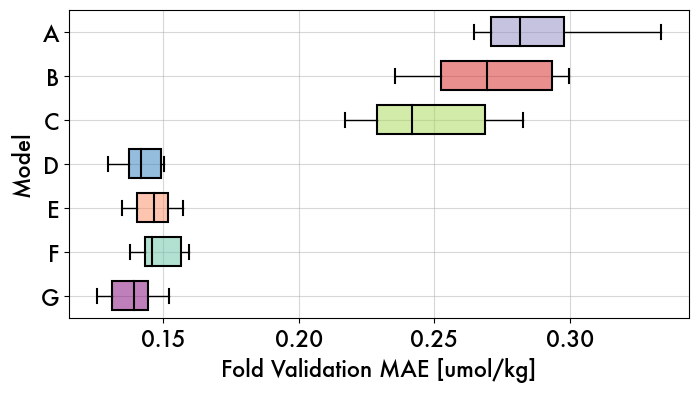

In [70]:
# Plot boxplots for 10 MAEs per model
data = cv_kfold.MAEs  
fig, ax = plt.subplots(figsize=(8,4))

lw= 1.5
bplot = ax.boxplot(data.values(), widths=0.65, vert=False, patch_artist=True,
                   medianprops = {'color':'k', 'linewidth':lw},
                   capprops= {'color':'k', 'linewidth':lw},
                   flierprops= {'color':'k', 'linewidth':lw},
                   boxprops = {'color':'k', 'linewidth':lw})
ax.set_yticklabels([x[-1] for x in data.keys()])
ax.grid(zorder=1, alpha=0.5)
ax.invert_yaxis()
ax.set_ylabel('Model')
ax.set_xlabel('Fold Validation MAE [umol/kg]')

colors = []
for mdl in model_list:
    colors.append(model_palettes[mdl])

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(matplotlib.colors.to_rgba(color, alpha=0.5))

plt.show()

## 6.3 CV Bias by depth between models D and G

In [46]:
# Create datasets for comparison, binned in 100m depth ranges

pressure_ranges = [(0, 100), (100, 200), (200, 300), (300, 400), (400, 500),
                    (500, 600) ] #(600, 700), (700, 800), (800, 900), (900, 1000)]
mod_one = 'Model_D'
mod_two = 'Model_G'

bias_one = crf.get_depth_bias(cv_kfold.val_DF[mod_one], pressure_ranges)
bias_two = crf.get_depth_bias(cv_kfold.val_DF[mod_two], pressure_ranges)

In [80]:
size = 16
plt.style.use('default')
params = {'legend.fontsize': size, 
          'xtick.labelsize':size, 
          'ytick.labelsize':size, 
          'font.size':size,
          'font.family':'Futura',
          'mathtext.fontset':'stixsans',
          'mathtext.bf':'STIXGeneral:bold'}
plt.rcParams.update(params)

# rcParams['mathtext.bf'] = 'STIXGeneral:italic:bold'

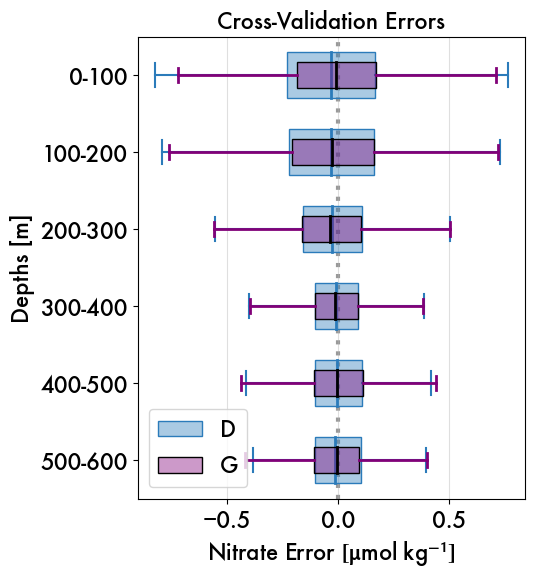

In [78]:
# Plot comparison boxplots of errors by depth

color_one = model_palettes['Model_D'] # sns.color_palette("Purples")[3]
color_two = model_palettes['Model_G']

# Make figure 
fig = plt.figure(figsize=(5,6))  # paper: 10,13
ax = fig.gca()

bplot_one = ax.boxplot(bias_one.values(), vert=False, showfliers=False, widths=0.6, 
                    patch_artist=True, 
                    medianprops= {'color':color_one, 'linewidth':2},
                    capprops={'color':color_one, 'linewidth':1.5},
                    whiskerprops={'color':color_one, 'linewidth':1.5},
                    flierprops={'color':color_one, 'linewidth':1.5},
                    boxprops = {'color':color_one, 'linewidth':1},
                    zorder=2)
for patch, color in zip(bplot_one['boxes'], [color_one]*10):
    patch.set_facecolor(matplotlib.colors.to_rgba(color, alpha=0.4))


bplot_two = ax.boxplot(bias_two.values(), vert=False, showfliers=False, widths=0.35, 
                    patch_artist=True, 
                    medianprops= {'color':'k', 'linewidth':2},
                    capprops={'color':color_two, 'linewidth':2},
                    whiskerprops={'color':color_two, 'linewidth':2},
                    flierprops={'color':color_two, 'linewidth':2},
                    boxprops = {'color':'k', 'linewidth':1},
                    zorder=3)
for patch, color in zip(bplot_two['boxes'], [color_two]*10):
    patch.set_facecolor(matplotlib.colors.to_rgba(color, alpha=0.4))

ax.invert_yaxis()
ax.axvline(x=0, color='k', linestyle='dotted', linewidth=3, alpha=0.4, zorder=0)

umol_unit = (r'$\mathbf{[\mu} \mathregular{mol~kg} \mathbf{^{-1}]}$')
labels = bias_one.keys()
plt.yticks(range(1, len(labels) + 1), labels)
plt.ylabel("Depths [m]")
plt.xlabel("Nitrate Error " + umol_unit)
plt.title("Cross-Validation Errors", fontsize=16)

ax.legend([bplot_one["boxes"][0], bplot_two["boxes"][0]], [mod_one[-1], mod_two[-1]], loc='lower left')
ax.grid(axis='x', zorder=1, alpha=0.4)

## 6.4: CV Errors - Probability Density Estimation

In [62]:
size = 16
plt.style.use('default')
params = {'legend.fontsize': size, 
          'xtick.labelsize':size, 
          'ytick.labelsize':size, 
          'font.size':size,
          'font.family':'Futura',
          'mathtext.fontset':'stixsans',
          'mathtext.bf':'STIXGeneral:bold'}
plt.rcParams.update(params)


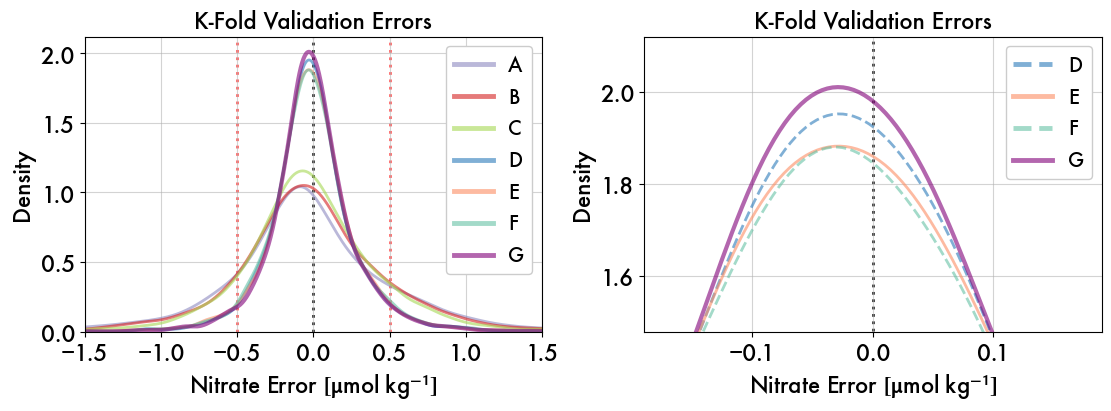

In [88]:
# New KDE plot using all validation errors from K-Fold 
tag = 'Predicted - Observed Nitrate'
var = 'val_error'; ymax=2.12
data = cv_kfold.val_error
# ymax = 2.1


# Make Figure with 2 Subplots
fig, axs = plt.subplots(1, 2, figsize=(11,4), layout='constrained')
axs=axs.flatten()

for ax in axs[0:1]:
    for mod in model_list[:]: 
        RF = data[mod].values

        # Add Gaussian KDE to estimate probability density function
        x = np.linspace(RF.min(), RF.max(), 1000)
        kde = scipy.stats.gaussian_kde(RF)

        lw = 2; ls = 'solid'
        if mod == 'Model_G':
            lw=lw+1
        ax.plot(x, kde(x), color=model_palettes[mod], linewidth=lw, linestyle=ls, label=mod[-1], alpha=0.6)

    if var == 'val_error':
        ax.set_xlim([-1.5, 1.5])
        ax.set_ylim([0, ymax])

    leg = ax.legend(fontsize=14, framealpha=1)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.5)
    

for ax in axs[1:]:
    for mod in model_list[3:]: # ['Model_A', 'Model_G']: #
        RF = data[mod].values

        # Gaussian KDE
        x = np.linspace(RF.min(), RF.max(), 1000)
        kde = scipy.stats.gaussian_kde(RF)

        lw = 2; ls = 'solid'
        if mod == 'Model_G':
            lw=lw+1
        if mod in ['Model_D', 'Model_F']:
            ls = '--'
        plt.plot(x, kde(x), color=model_palettes[mod], linewidth=lw, linestyle = ls, label=mod[-1], alpha=0.6)

    ax.set_xlim([-.19, .19])
    ax.set_ylim([1.48, ymax])

    # Legend
    leg = plt.legend(fontsize=14, framealpha=1)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.5)

umol_unit = (r'$\mathbf{[\mu} \mathregular{mol~kg} \mathbf{^{-1}]}$')


for ax in axs:
    # Show float uncertainty and 0 line
    ax.axvline(x=0.5, color='r', linestyle='dotted', linewidth=2, alpha=0.6, zorder=0)
    ax.axvline(x=-0.5, color='r', linestyle='dotted', linewidth=2, alpha=0.6, zorder=0)
    ax.vlines(0, ymin=0, ymax=3, colors='k', alpha=0.8, linewidth=2, linestyle='dotted', zorder=1)
    # ax.set_ylim([0,ymax])
    ax.grid(alpha=0.55, zorder=1)

    ax.set_ylabel('Density')
    ax.set_xlabel("Nitrate Error " + umol_unit)
    ax.set_title('K-Fold Validation Errors', fontsize=16)


In [ ]:
# Bias 

# PART 7: Spatial Leave-One-Out Cross-Validation

- To use this section, make sure your training/val/test data is properly defined in section 2.1.2
- Use Leave One Out holdout validation

### Make additional "holdout" datasets for spatial blocking

- The particular training_holdout['5906030'], etc. are essentially the data we will be using to develop the model by running cell block 2.1.2
- That is, we want to make the training and validation from an 80/20 split of all the data except the SOGOS 

In [92]:
importlib.reload(crf)

<module 'class_RF' from '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/RandomForest_SG/scripts/class_RF.py'>

In [93]:
# Create datasets for LOO Validation
wmos = [x for x in wmoids if x != 5906030] 
[loo_training, loo_validation] = crf.split_loos(wmos, floatDF, shipDF)

# make holdout datasets from floats and add ship 
# keep track of #obs in each dataset
nobs_training = []; nobs_validation=[]; nobs_test=[]
for wmo in wmos:
    nobs_training.append(len(loo_training[wmo]))
    nobs_validation.append(len(loo_validation[wmo]))

dict = {'wmoid withheld': wmos, 'training obs': nobs_training, 'validation obs (withheld)': nobs_validation}
nobs_holdout = pd.DataFrame(dict)
print("# observations for spatially blocked data:"); print(nobs_holdout)

# observations for spatially blocked data:
   wmoid withheld  training obs  validation obs (withheld)
0         5904469         13537                       1041
1         5904659         12034                       2544
2         5905368         13090                       1488
3         5905996         11092                       3486
4         5906031         11322                       3256
5         5906207         12057                       2521


## 7.1 Single Model Spatial LOO

k=10


$k=10$


In [116]:
loomodel = 'Model_D'
ntrees = 1000
max_feats = 1/3
min_samples_split = 5
desc = 'full'
description = 'Hyperparameters: trees=' + str(ntrees) + ', max_features=' + str(max_feats)

print(description + '\n')

# Create the RF
wmos = [x for x in wmoids if x != 5906030] 
RF_loo = crf.ModelVersion(wmos) # Let wmos be the index

for k in tqdm(wmos): 
    [RF_loo.models[k], RF_loo.MAE[k], RF_loo.IQR[k], 
     RF_loo.r2[k], RF_loo.DF_err[k], 
     RF_loo.val_err[k]] = train_RF(var_list[loomodel], 
                            loo_training[k], loo_validation[k], test, 
                            ntrees = ntrees, max_feats = max_feats,
                            min_samples_split=min_samples_split)

loo_metrics = RF_loo.get_metrics()


save=True
if save:
    for wmo in wmos:
        RF_loo.val_err[wmo].to_csv('../working-vars/RF-crossval/loo_valDF_' + loomodel + '_' + str(wmo) + '_' + desc + '.csv')

Hyperparameters: trees=1000, max_features=0.3333333333333333



100%|██████████| 6/6 [01:21<00:00, 13.63s/it]


In [ ]:
# To save
save=True
if save:
    for wmo in wmos:
        # If you just ran the above, this will only give you Model G
        RF_loo.val_err[wmo].to_csv('../working-vars/RF-crossval/loo_valDF_' + loomodel + '_' + str(wmo) + '_' + desc + '.csv')

## 7.2 Comprehensive LOO across Model X's

In [36]:
wmoids = floatDF.wmoid.unique()
var_list = {
            'Model_A': ['spice', 'sigma0'],
            'Model_B': ['CT', 'SA', 'pressure'], 
            'Model_C': ["CT", "SA", "pressure", 'oxygen'],
            'Model_D': ["CT", "SA", "pressure", "oxygen", 'lat', 'lon', 'yearday'],
            'Model_E': ["CT", "SA", 'pressure', 'oxygen', 'lat', 'lon', 'yearday', 'o2sat'],
            'Model_F': ["CT", "SA", 'pressure', 'oxygen', 'lat', 'lon', 'yearday', 'log_buoyancy'],
            'Model_G': ["CT", "SA", 'pressure', 'oxygen', 'lat', 'lon', 'yearday', 'ydcos', 'ydsin']
            }

model_list = list(var_list.keys())

In [37]:
rerun = True 
desc='full'
loomodel = 'Model_G'
wmos = [x for x in wmoids if x != 5906030] 

RF_loo = rfr.ModelVersion(wmos)
if rerun: 
    cvloo_metrics = pd.read_csv('../working-vars/RF-crossval/loo_all_metrics_' + desc + '.csv')
for wmo in wmos:
    RF_loo.val_err[wmo] = pd.read_csv('../working-vars/RF-crossval/loo_valDF_' + loomodel + '_' + str(wmo) + '_' + desc + '.csv')

cvloo = {}
for model in model_list:
    cvloo[model] = cvloo_metrics[model].values

In [112]:
# To run LOO the first time
ntrees = 1000
max_feats = 1/3
min_samples_split = 5
desc = 'full'
description = 'Hyperparameters: trees=' + str(ntrees) + ', max_features=' + str(max_feats)

# WARNING
# UNCOMMENT NEXT LINE, OR CVLOO WILL RESET
# cvloo = {} # will become dictionary holding maes across models
wmos = [x for x in wmoids if x != 5906030] 

for loomodel in model_list[:2]: 
    RF_loo = crf.ModelVersion(wmos) # Let wmos be the index

    for k in tqdm(wmos): 
        [RF_loo.models[k], RF_loo.MAE[k], RF_loo.IQR[k], 
        RF_loo.r2[k], RF_loo.DF_err[k], 
        RF_loo.val_err[k]] = train_RF(var_list[loomodel], 
                                loo_training[k], loo_validation[k], test, 
                                ntrees = ntrees, max_feats = max_feats,
                                min_samples_split=min_samples_split)

    cvloo[loomodel] = RF_loo.get_metrics()['validation_MAE'].values

cvloo_metrics = pd.DataFrame.from_dict(cvloo)
cvloo_metrics['wmo'] = wmos
cvloo_metrics = cvloo_metrics.set_index('wmo')[model_list]
# cvloo_metrics[model_list]

100%|██████████| 6/6 [00:59<00:00,  9.98s/it]


In [96]:
for wmo in wmos: 
    print(np.abs(RF_loo.DF_err[wmo].test_error).mean())

0.27397815225211647
0.2966909075504853
0.29222927490920136
0.28881575268487936
0.3267265892673135
0.29911966572160087


In [20]:
save=False
# model = 'Model_G' 
if save:
    cvloo_metrics[model_list].to_csv('../working-vars/RF-crossval/loo_all_metrics_' + desc + '.csv')
    # kfold_list_MAEs.to_csv('../working-vars/RF-crossval/kfold_list_MAEs_' + desc + '.csv')
    for wmo in wmos:
        # If you just ran the above, this will only give you Model G
        RF_loo.val_err[wmo].to_csv('../working-vars/RF-crossval/loo_valDF_' + model + '_' + str(wmo) + '_' + desc + '.csv')

[Text(0, 0, 'A'),
 Text(1, 0, 'B'),
 Text(2, 0, 'C'),
 Text(3, 0, 'D'),
 Text(4, 0, 'E'),
 Text(5, 0, 'F'),
 Text(6, 0, 'G')]

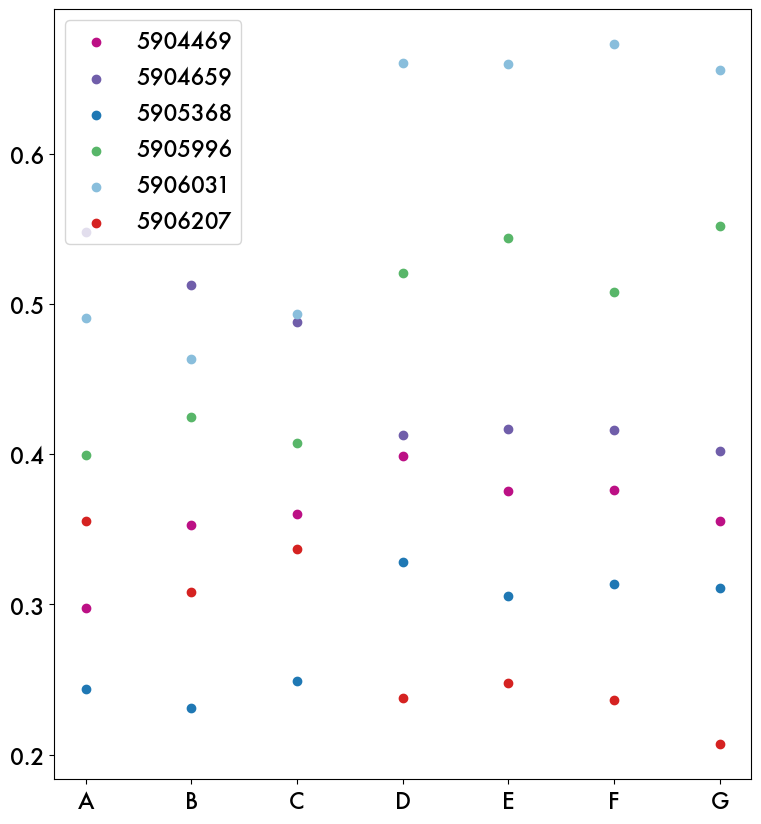

In [42]:
fig = plt.figure(figsize=(9,10))
ax = fig.gca()
cpal = sns.color_palette('Set2', n_colors=6)

for wmo in wmos: 
    for ind, mdl in enumerate(model_list):
        if ind== 0:
            ax.scatter(ind, cvloo_metrics.at[wmo, mdl], color=wmo_colors[wmo], label=wmo)
        else: 
            ax.scatter(ind, cvloo_metrics.at[wmo, mdl], color=wmo_colors[wmo])

    
ax.legend(loc='upper left', fontsize=16)
ax.set_xticks(np.arange(0,7))
ax.set_xticklabels([x[-1] for x in model_list])
# ax.set_ylim([0,100])


In [62]:
importlib.reload(sgplot)
from mod_plotting import umol_unit

In [96]:
plt.style.use('default')
params = {'legend.fontsize': size, 
          'xtick.labelsize':size, 
          'ytick.labelsize':size, 
          'font.size':size,
          'font.family':'Futura',
          'mathtext.fontset':'stixsans',
          'mathtext.bf':'STIXGeneral:bold'}
umol_unit = (r'$\mathbf{[\mu} \mathregular{mol~kg} \mathbf{^{-1}]}$')

plt.rcParams.update(params)

In [92]:
from mod_plotting import *
plt.rcParams.update(get_rcParams())

In [90]:
# umol_unit = (r'$\mathbf{[\mu} \mathregular{mol~kg} \mathbf{^{-1}]}$')

In [192]:
cvloo

{'Model_A': array([0.29781938, 0.54816   , 0.24370729, 0.39966399, 0.49046508,
        0.35551297]),
 'Model_B': array([0.35299778, 0.51295862, 0.231341  , 0.42463185, 0.46327453,
        0.30805412]),
 'Model_C': array([0.35993456, 0.487748  , 0.24901796, 0.40724401, 0.49364116,
        0.33663364]),
 'Model_D': array([0.39903987, 0.41295037, 0.32833806, 0.52042098, 0.66049031,
        0.23756372]),
 'Model_E': array([0.37570768, 0.41652674, 0.30540908, 0.5441512 , 0.65963228,
        0.24791143]),
 'Model_F': array([0.37646072, 0.41581348, 0.31361565, 0.50826401, 0.67297617,
        0.23609626]),
 'Model_G': array([0.35568348, 0.40219551, 0.31120501, 0.55188037, 0.65585632,
        0.20686669])}

In [193]:
cvloo_metrics

Unnamed: 0   Model_A   Model_B   Model_C   Model_D   Model_E  \
wmo                                                                     
5904469           0  0.297819  0.352998  0.359935  0.399040  0.375708   
5904659           1  0.548160  0.512959  0.487748  0.412950  0.416527   
5905368           2  0.243707  0.231341  0.249018  0.328338  0.305409   
5905996           3  0.399664  0.424632  0.407244  0.520421  0.544151   
5906031           4  0.490465  0.463275  0.493641  0.660490  0.659632   
5906207           5  0.355513  0.308054  0.336634  0.237564  0.247911   

          Model_F   Model_G  
wmo                          
5904469  0.376461  0.355683  
5904659  0.415813  0.402196  
5905368  0.313616  0.311205  
5905996  0.508264  0.551880  
5906031  0.672976  0.655856  
5906207  0.236096  0.206867

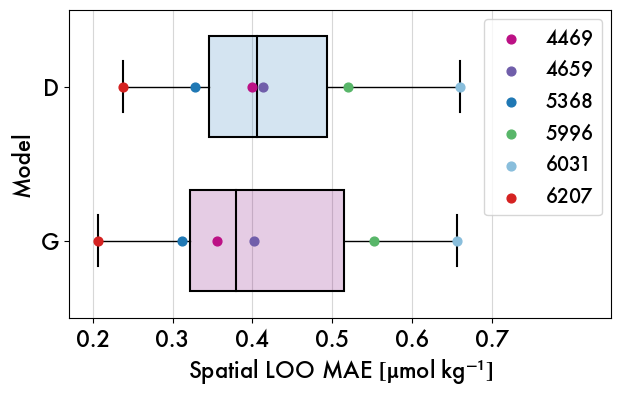

In [113]:
# Plot boxplots for 6 different LOO's
data = {k: cvloo[k] for k in ('Model_D', 'Model_G')}
fig, ax = plt.subplots(figsize=(7,4))

lw= 1.5
bplot = ax.boxplot(data.values(), widths=0.65, vert=False, patch_artist=True,
                   medianprops = {'color':'k', 'linewidth':lw},
                   capprops= {'color':'k', 'linewidth':lw},
                   flierprops= {'color':'k', 'linewidth':lw},
                   boxprops = {'color':'k', 'linewidth':lw})
ax.set_yticklabels([x[-1] for x in data.keys()])

ax.grid(axis='x', zorder=1, alpha=0.5)
ax.set_ylabel('Model')
ax.set_xlabel('Spatial LOO MAE ' + umol_unit)
ax.set_xticks([.2, .3, .4, .5, .6, .7])


colors = [model_palettes['Model_D'], model_palettes['Model_G']]
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(matplotlib.colors.to_rgba(color, alpha=0.2))


for wmo in wmos: 
        ax.scatter(cvloo_metrics.at[wmo,'Model_D'],1, color=wmo_colors[wmo], s = 40, label= str(wmo)[-4:], zorder=3)
        ax.scatter(cvloo_metrics.at[wmo,'Model_G'],2, color=wmo_colors[wmo], s=40, zorder=3)

ax.legend(loc='upper right', fontsize=14)
ax.set_xlim([.17, .85])
ax.invert_yaxis()
# 


In [56]:
from mod_plotting import umol_unit

In [403]:
# Save loo metrics
# cvloo_metrics.to_csv('../working-vars/RF-crossval/loo_metrics_' + desc + '.csv')

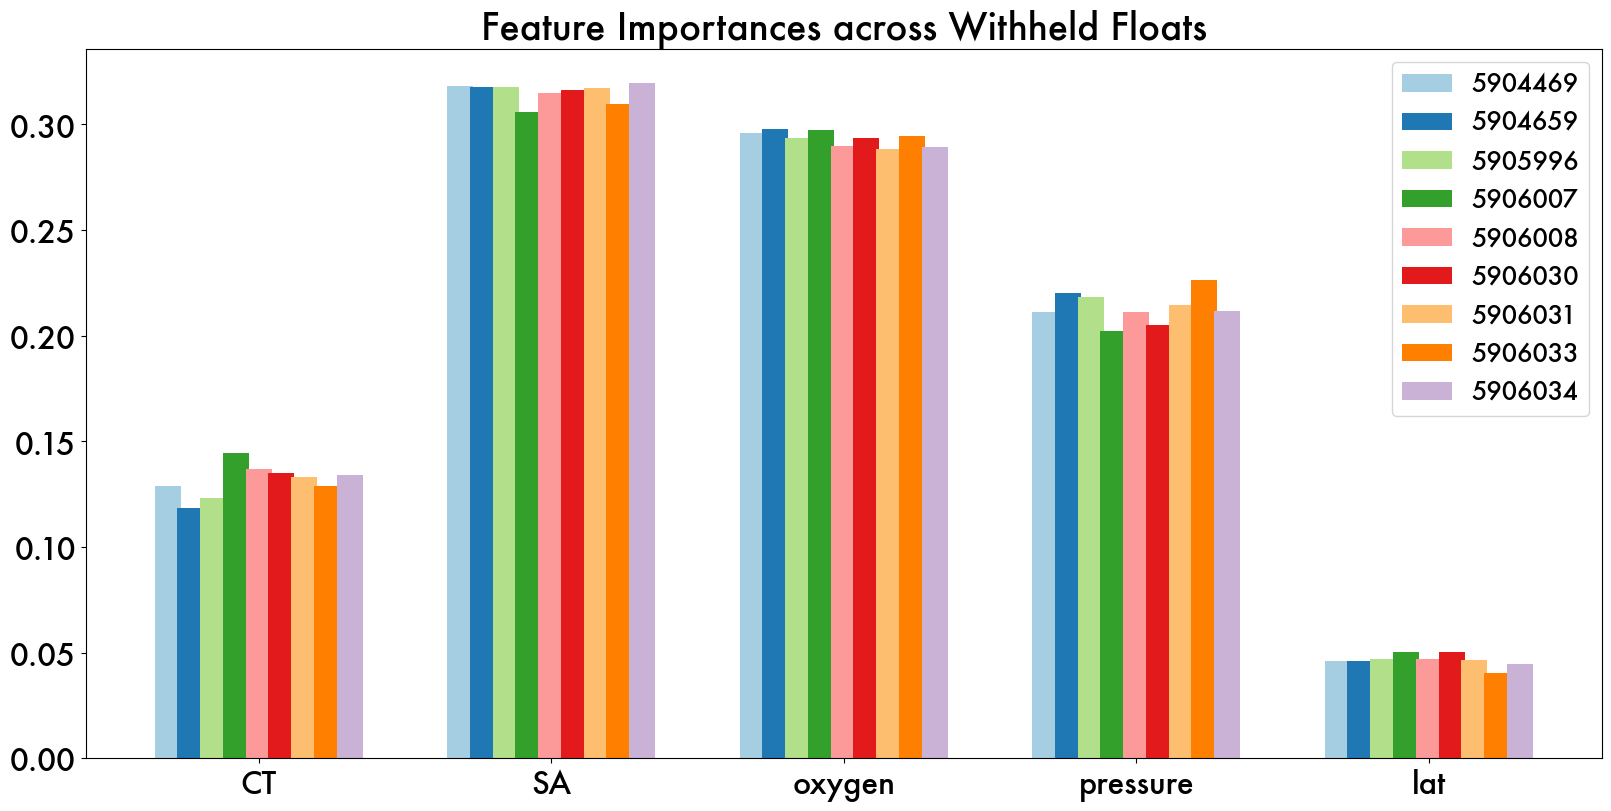

In [ ]:
# Compare feature importance across LOO iterations for a given model
fig = plt.figure(figsize=(16,8), layout='constrained')
ax = fig.gca()

barwidth=.7

xind = dict.fromkeys(wmoids)
xind[wmoids[0]] = np.arange(5)*9
for i in range(8):
    xind[wmoids[i+1]] = [x + barwidth for x in xind[wmoids[i]]]

for wmo in wmoids:
    ax.bar(xind[wmo], Mdl_holdout_5[wmo].feature_importances_, label=wmo, color=wmo_colors[wmo])

### 

# x = np.arange(5)*10  # the label locations
# width = 0.75  # the width of the bars
# multiplier = 0
ax.set_xticks(xind[wmoids[4]])
ax.set_xticklabels(var_list['Mdl_5B'])
ax.set_title('Feature Importances across Withheld Floats')
ax.legend()

# PART 5: RF Test Error Analysis

## 5.0 Plot Error Distributions (Histograms)

Text(0.5, 1.0, 'Comparison of Nitrate Distributions for SOGOS Platforms')

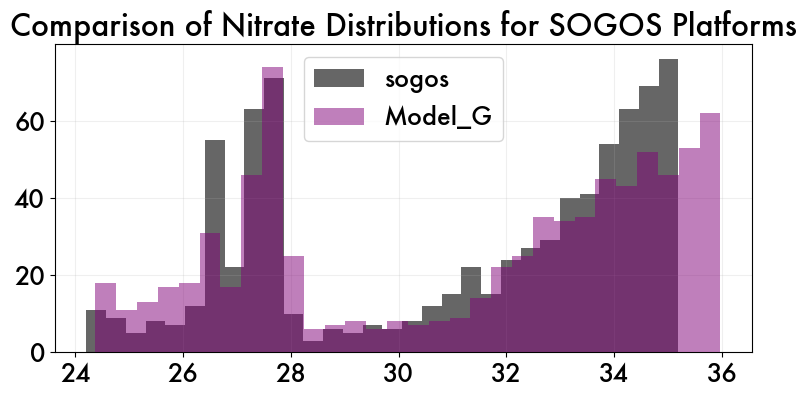

In [107]:
# Plot nitrate distributions
mod = 'Model_G'
dat = RF_full.DF_err[mod]
dat = dat[dat.yearday<200]
fig = plt.figure(figsize=(9,4))
ax = fig.gca()

ax.grid(zorder=0, alpha=0.2)
plt.hist(dat['nitrate'], bins=30, alpha=0.6, label='sogos', color='k', zorder=1)
plt.hist(dat['test_prediction'], bins=30, alpha=0.5, label=mod, color=model_palettes[mod], zorder=3)
    
plt.legend()
ax.set_title('Comparison of Nitrate Distributions for SOGOS Platforms')

## 5.1 Plot Nitrate and Error Sections (Time-Depth)

In [4]:
model_list = ['Model_A', 'Model_B', 'Model_C', 'Model_D', 'Model_E', 'Model_F', 'Model_G']


In [26]:
# Download data and metrics from the RF training
dir = '../working-vars/RF-training/'
# Import data output from RF training
RF_validation = dict.fromkeys(model_list)
RF_test = dict.fromkeys(model_list)
RF_modelmetrics = pd.read_csv(dir + 'mlresult_model_metrics_full.csv')
RF_featimps = pd.read_csv(dir + 'mlresult_feat_imps_full.csv').set_index('Mdl')

# Use RF_test in place of RF_ver[4]
# Use RF_validation in place of RF_ver[5]
for modtag in model_list:
    filename = 'mlresult_test_err_' + modtag[-1] + '_full.csv'
    RF_test[modtag] = pd.read_csv(dir + filename)
    filename = 'mlresult_val_err_' + modtag[-1] + '_full.csv'
    RF_validation[modtag] = pd.read_csv(dir + filename)

# Download cross validation 
dir = '../working-vars/RF-crossval/'
RF_loo = pd.read_csv(dir + 'loo_all_metrics_full.csv')
RF_kfold = pd.read_csv(dir + 'kfold_all_metrics_full.csv')

# Full non-qc'ed float data from wmo 6030
# Only used to plot mld over the comparison section
dav_6030 = pd.read_csv('../data/bgc-argo/dav_full6030_noqc.csv')
# dav_6030


Unnamed: 0      profid      yearday     lat      lon         mld
0             0  5906030000   120.374294 -51.355   30.208  110.387154
1             1  5906030001   125.159699 -51.074   32.828   99.488426
2             2  5906030002   130.068877 -51.796   31.632   89.316162
3             3  5906030003   135.173252 -52.452   31.764   84.632133
4             4  5906030004   140.063449 -51.856   33.445   72.162811
..          ...         ...          ...     ...      ...         ...
161         161  5906030161  1705.302280 -46.845  104.700  267.876923
162         162  5906030162  1715.673252 -47.040  106.254  218.220612
163         163  5906030163  1725.990336 -46.642  109.259  292.143188
164         164  5906030164  1736.343542 -47.493  110.733  182.868744
165         165  5906030165  1746.815544 -47.723  111.012  142.867859

[166 rows x 6 columns]

In [12]:
np.nanmean(RF_test['Model_G']['test_relative_error'])

0.002200894559102698

In [135]:
gtest = RF_test['Model_G']
testerr = gtest.test_error #[gtest.yearday<200]
abstest = (np.abs(testerr))

0.2896955789126086

In [136]:

df = RF_test['Model_G']
len(df[np.abs(df.test_error) < 0.5])/len(df)


0.840689238210399

In [137]:
data = np.abs(RF_test['Model_G'].test_error)
mean = np.mean(data); std_dev = np.std(data)
low = mean - 2 * std_dev
high = mean + 2 * std_dev

In [138]:
high

0.7322709337252822

In [134]:
rfr.print_errors(RF_test['Model_G'], var='test_error')

Error metric: test_error
Restricted to depths 0 to 1000:
median abs error: 	0.20341177371638605
mean abs error 		0.267359791753317

95% of errors fall between:
-0.6072 to 0.77137

During SOGOS between depths 0 to 1000:
95% of errors fall between:
-0.6478 to 1.05943


dat

In [28]:
dav_6030

Unnamed: 0      profid      yearday     lat      lon         mld
0             0  5906030000   120.374294 -51.355   30.208  110.387154
1             1  5906030001   125.159699 -51.074   32.828   99.488426
2             2  5906030002   130.068877 -51.796   31.632   89.316162
3             3  5906030003   135.173252 -52.452   31.764   84.632133
4             4  5906030004   140.063449 -51.856   33.445   72.162811
..          ...         ...          ...     ...      ...         ...
161         161  5906030161  1705.302280 -46.845  104.700  267.876923
162         162  5906030162  1715.673252 -47.040  106.254  218.220612
163         163  5906030163  1725.990336 -46.642  109.259  292.143188
164         164  5906030164  1736.343542 -47.493  110.733  182.868744
165         165  5906030165  1746.815544 -47.723  111.012  142.867859

[166 rows x 6 columns]

In [38]:
dat

Unnamed: 0     yearday     lat     lon    pressure        CT         SA  \
0              0  120.374294 -51.355  30.208   33.059998  3.646815  34.001027   
1              1  120.374294 -51.355  30.208   35.230000  3.646676  34.001041   
2              2  120.374294 -51.355  30.208   36.670000  3.646283  34.001036   
3              3  120.374294 -51.355  30.208   46.730000  3.648244  34.001074   
4              4  120.374294 -51.355  30.208   52.360000  3.639289  34.002073   
...          ...         ...     ...     ...         ...       ...        ...   
3303        3303  691.905764 -57.596  64.892  801.720030  2.179182  34.840148   
3304        3304  691.905764 -57.596  64.892  851.370000  2.156246  34.848747   
3305        3305  691.905764 -57.596  64.892  902.080000  2.134686  34.862375   
3306        3306  691.905764 -57.596  64.892  951.700000  2.086429  34.869113   
3307        3307  691.905764 -57.596  64.892  999.580000  2.070541  34.881759   

         oxygen     sigma0  log_buoyancy  ...       o2sat     ydcos     ydsin  \
0     326.35095  26.900994    -19.750025  ...  320.309034 -0.480611  0.876934   
1     326.34912  26.901019    -15.410772  ...  320.310085 -0.480611  0.876934   
2     326.32490  26.901053    -15.336909  ...  320.313152 -0.480611  0.876934   
3     326.13754  26.900892    -13.446538  ...  320.297846 -0.480611  0.876934   
4     326.04580  26.902555    -13.096893  ...  320.365141 -0.480611  0.876934   
...         ...        ...           ...  ...         ...       ...       ...   
3303  175.33665  27.698522    -13.153399  ...  329.951166  0.792583 -0.609763   
3304  176.85205  27.707240    -13.061677  ...  330.118224  0.792583 -0.609763   
3305  178.92215  27.719843    -13.003560  ...  330.261126  0.792583 -0.609763   
3306  180.15717  27.729116    -13.068774  ...  330.642598  0.792583 -0.609763   
3307  183.09941  27.740466    -13.068774  ...  330.741510  0.792583 -0.609763   

        nitrate    wmoid      profid   dist_maxb  test_prediction  test_error  \
0     24.327644  5906030  5906030000  117.879992        24.371918    0.044274   
1     24.310630  5906030  5906030000  115.709990        24.372461    0.061831   
2     24.337334  5906030  5906030000  114.269990        24.375855    0.038521   
3     24.227932  5906030  5906030000  104.209990        24.372668    0.144736   
4     24.203530  5906030  5906030000   98.579990        24.408616    0.205086   
...         ...      ...         ...         ...              ...         ...   
3303  33.055695  5906030  5906030063 -552.340030        33.218852    0.163157   
3304  32.948257  5906030  5906030063 -601.990000        32.917235   -0.031022   
3305  32.480873  5906030  5906030063 -652.700000        32.540317    0.059444   
3306  32.307697  5906030  5906030063 -702.320000        32.323041    0.015344   
3307  31.848587  5906030  5906030063 -750.200000        31.965165    0.116578   

      test_relative_error  
0                0.001820  
1                0.002543  
2                0.001583  
3                0.005974  
4                0.008473  
...                   ...  
3303             0.004936  
3304            -0.000942  
3305             0.001830  
3306             0.000475  
3307             0.003660  

[3308 rows x 21 columns]

Text(0.5, 1.0, 'RF Nitrate Prediction')

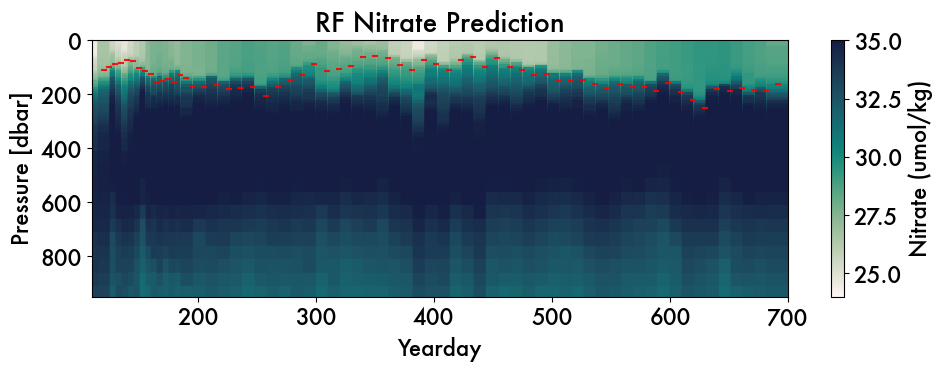

In [42]:
# Section of Model G prediction
dat = RF_test['Model_G']  # (or RF_full.DF_err)
fig  = plt.figure(figsize=(10,4), tight_layout=True)
ax = plt.gca()

sca = ax.scatter(dat.yearday, dat.pressure, c=dat.test_prediction, cmap=cmo.tempo, s=250, marker='s', vmin=24, vmax=35)
# sca = ax.scatter(dat.yearday, dat.pressure, c=dat.sigma0, cmap=cmo.tempo, s=250, marker='s')
ax.scatter(dav_6030.yearday, dav_6030.mld, c='r', s=20, marker='_', alpha=0.9, label='MLD')
plt.colorbar(sca, ax=ax).set_label('Nitrate (umol/kg)')

ax.invert_yaxis()
ax.set_ylabel('Pressure [dbar]')
ax.set_xlabel('Yearday')

ax.set_xlim([110,700])
ax.set_ylim([950,0])
ax.set_title('RF Nitrate Prediction')

# plt.savefig('../figures/ModelG_observation_profmap.png', dpi=300, bbox_inches='tight')

(950.0, 0.0)

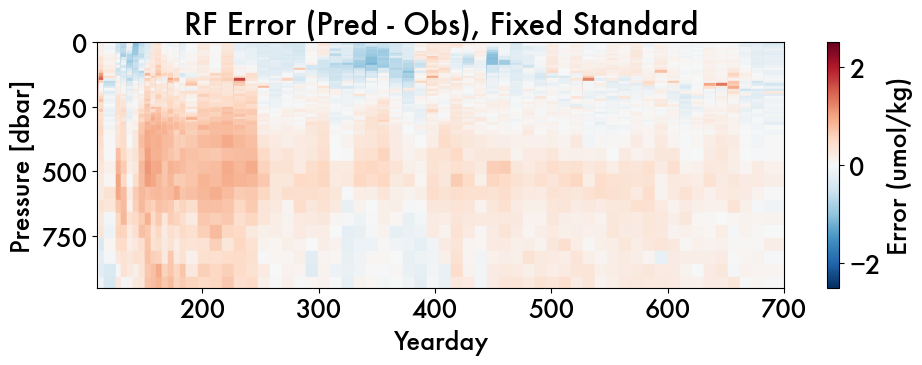

In [110]:
# SINGLE ERROR PROFILE
dat = RF_full.DF_err['Model_G']

fig  = plt.figure(figsize=(10,4), tight_layout=True)
ax = plt.gca()
sca = ax.scatter(dat.yearday, dat.pressure, c=dat.test_error, cmap='RdBu_r', s=250, marker='s' , vmin=-2.5, vmax=2.5)
plt.colorbar(sca, ax=ax).set_label('Error (umol/kg)')

ax.set_title('RF Error (Pred - Obs), Fixed Standard')
ax.invert_yaxis()
ax.set_ylabel('Pressure [dbar]')
ax.set_xlabel('Yearday')

ax.set_xlim([110,700])
ax.set_ylim([950,0])


(950.0, 0.0)

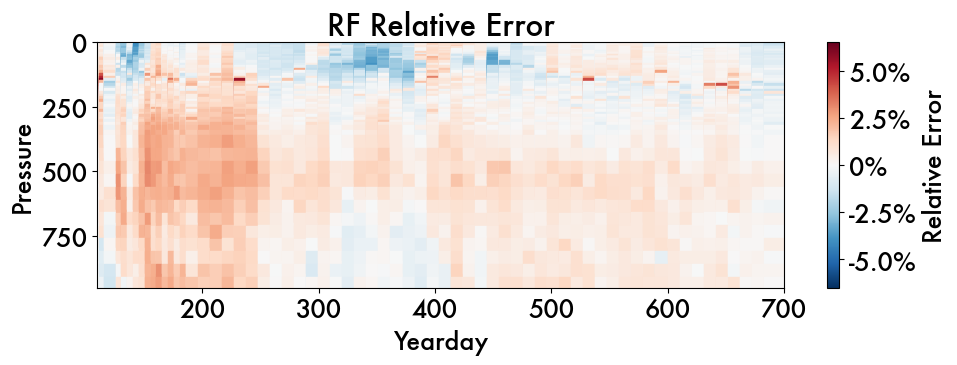

In [111]:
# SINGLE TEST RELATIVE ERROR PROFILE
dat = RF_full.DF_err['Model_G']

fig  = plt.figure(figsize=(10,4), tight_layout=True)
ax = plt.gca()
sca = ax.scatter(dat.yearday, dat.pressure, c=dat.test_relative_error, cmap='RdBu_r', s=250, marker='s', vmin=-.065, vmax=.065)

# ticklist = [-0.04, -0.02, 0, 0.02, 0.04] 
ticklist = [-0.05, -0.025, 0, 0.025, 0.05]
cbar = plt.colorbar(sca, ax=ax, ticks=ticklist) # [-0.28, -0.025, 0, 0.025, 0.28]
cbar.ax.set_yticklabels(['-5.0%', '-2.5%', '0%', '2.5%', '5.0%'])  # Setting tick labels here
cbar.set_label('Relative Error') 

ax.set_title('RF Relative Error')
ax.invert_yaxis()
ax.set_ylabel('Pressure')
ax.set_xlabel('Yearday')
# ax.set_xlim([120, 550])
# ax.set_ylim([600,0])

ax.set_xlim([110,700])
ax.set_ylim([950,0])


## 5.2 Plot Subplot Comparison Sections

In [18]:
from mod_plot import *

[Text(181, 0, "Jul '19"),
 Text(273, 0, "Oct '19"),
 Text(365, 0, "Jan '20"),
 Text(456, 0, "Apr '20"),
 Text(548, 0, "Jul '20"),
 Text(639, 0, "Oct '20")]

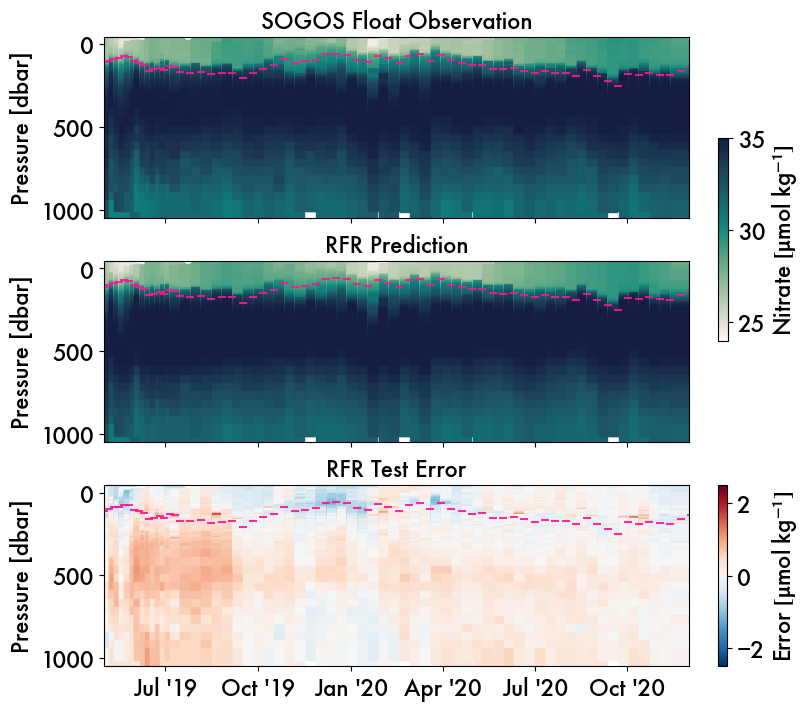

In [19]:
# * 3 Subplots: Prediction, Obs, and Error Profiles
# dat = RF_full.DF_err['Model_G']
dat = RF_test['Model_G']
tag = 'Model G'
type = 'absolute' # Choose absolute or relative errors here


fig, axs = plt.subplots(3,1, figsize=(8,7), layout='constrained', sharex=True)
axs = axs.flatten()

sca0 = axs[0].scatter(dat.yearday, dat.pressure, c=dat.nitrate, cmap=cmo.tempo, s=200, marker='s', vmin=24, vmax=35) #, vmin=0, vmax=0.005
axs[0].set_title('SOGOS Float Observation', fontsize=16) 


sca1 = axs[1].scatter(dat.yearday, dat.pressure, c=dat.test_prediction, cmap=cmo.tempo, s=200, marker='s', vmin=24, vmax=35) #, vmin=0, vmax=0.005
axs[1].set_title('RFR Prediction', fontsize=16)


fig.colorbar(sca0, ax=axs[0:2], shrink=0.5).set_label('Nitrate ' + umol_unit)

if type == 'absolute':
    sca2 = axs[2].scatter(dat.yearday, dat.pressure, c=dat.test_error, cmap='RdBu_r', s=200, marker='s', vmin=-2.5, vmax=2.5)
    axs[2].set_title('RFR Test Error', fontsize=16)
    fig.colorbar(sca2, ax=axs[2]).set_label('Error ' + umol_unit)

# elif type == 'relative':
#     sca2 = axs[2].scatter(dat.yearday, dat.pressure, c=dat.test_relative_error, cmap='RdBu_r', s=200, marker='s', vmin=-.06, vmax=.06)
#     axs[2].set_title('RFR Relative Error', fontsize=16)
#     ticklist = [-0.05, -0.025, 0, 0.025, 0.05] 
#     cbar = plt.colorbar(sca2, ax=axs[2], ticks=ticklist).set_label('Error ' + umol_unit)

for ax in axs[:]:
    ax.scatter(dav_6030.yearday, dav_6030.mld, c='deeppink', s=40, marker='_', alpha=0.9, label='MLD')

for ax in axs:
    ax.invert_yaxis()
    ax.set_xlim([120,700])
    ax.set_ylabel('Pressure [dbar]')


# xt = axs[2].get_xticks()
# axs[2].set_xticklabels(str(sg.ytd2datetime(k))[-8:] for k in xt)

xt = [181, 273, 365, 456, 548, 639]
axs[2].set_xticks(xt)
axs[2].set_xticklabels(str(sg.ytd2datetime(k))[-5:] for k in xt)
axs[2].set_xticklabels(['Jul \'19', 'Oct \'19','Jan \'20', 'Apr \'20', 'Jul \'20', 'Oct \'20'])

# axs[2].set_xlabel('[Yearday]')

## 5.3 Plotting in T-S Space

Text(0.5, 1.0, 'Test Prediction Errors Model G')

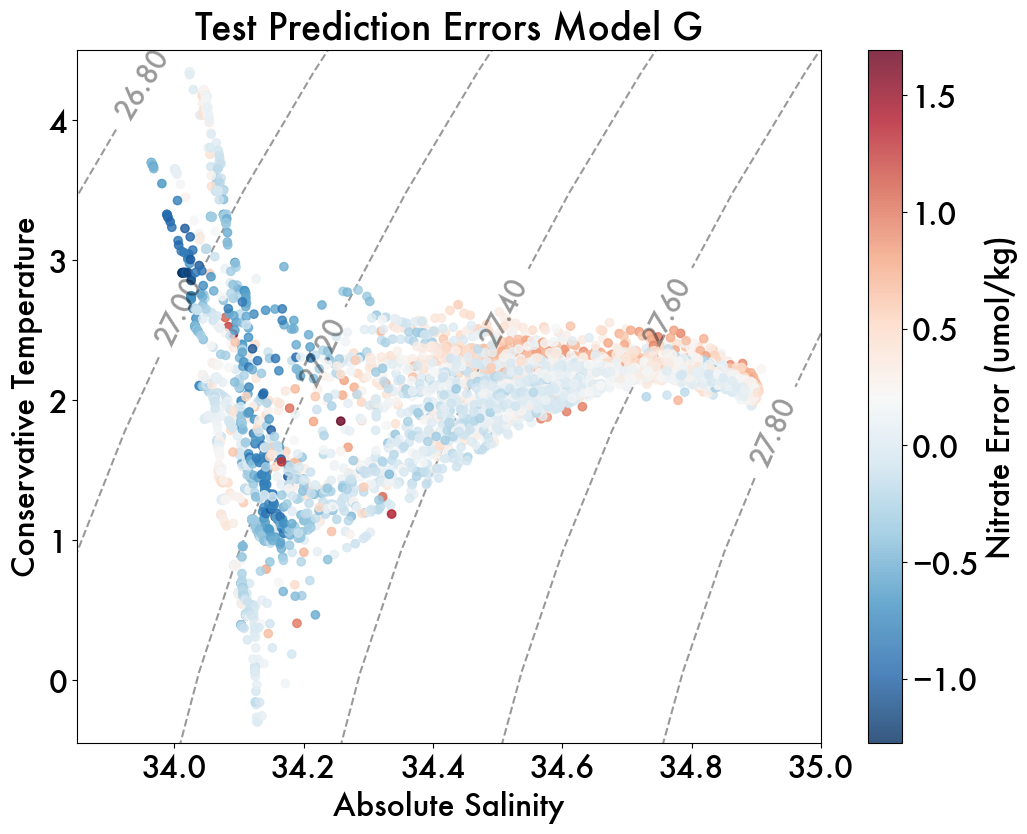

In [ ]:
# Errors in TS Space
df = RF_ver[4]['Model_G']
modtag = 'Model G'

fig = plt.figure(figsize=(12,9))
ax = fig.gca()
plt.scatter(df.SA, df.CT, c=df.test_error, cmap='RdBu_r', alpha=0.8, zorder=3)  # , vmin=-5, vmax=5
plt.colorbar().set_label('Nitrate Error (umol/kg)')
plt.show

# Add density contours
# Figure out boudaries (mins and maxs)
smin = df.SA.min() -.3
smax = df.SA.max() +.3

tmin= df.CT.min() - 1.5
tmax = df.CT.max() + 0.9

# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin

# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        dens[j,i]=gsw.sigma0(si[i],ti[j])

CS = ax.contour(si,ti,dens, linestyles='dashed', colors='k', alpha=0.4, zorder=1)
ax.clabel(CS, fontsize=20, fmt='%1.2f')
ax.set_ylim(-0.45,4.5)
ax.set_xlim(33.85, 35.0)

ax.set_xlabel('Absolute Salinity')
ax.set_ylabel('Conservative Temperature')
ax.set_title('Test Prediction Errors ' + modtag)


# PART 6: Comparison to ESPER/CANYON

In [5]:
# Load datasets to compare
sogos_float = RF_test['Model_G']

# After running CANYON and ESPER, make DataFrames
dir = '../working-vars/'
sogos_canyon = pd.read_csv(dir + 'CANYON-prediction/wmo5906030_MATLAB_canyon_pred_nov2023.csv')
sogos_esper = pd.read_csv(dir + '/ESPER-prediction/wmo5906030_MATLAB_esper_pred_nov2023.csv')

for var in ['pressure', 'yearday', 'nitrate']:
    sogos_canyon[var] = np.array(sogos_float[var])
    sogos_esper[var] = np.array(sogos_float[var])

sogos_canyon['prediction_error'] = sogos_canyon.prediction - sogos_canyon.nitrate
sogos_canyon['pred_relative_error'] = sogos_canyon.prediction_error/sogos_canyon.nitrate

sogos_esper['prediction_error'] = sogos_esper.prediction - sogos_esper.nitrate
sogos_esper['pred_relative_error'] = sogos_esper.prediction_error/sogos_esper.nitrate

Text(0.5, 0, 'Yearday')

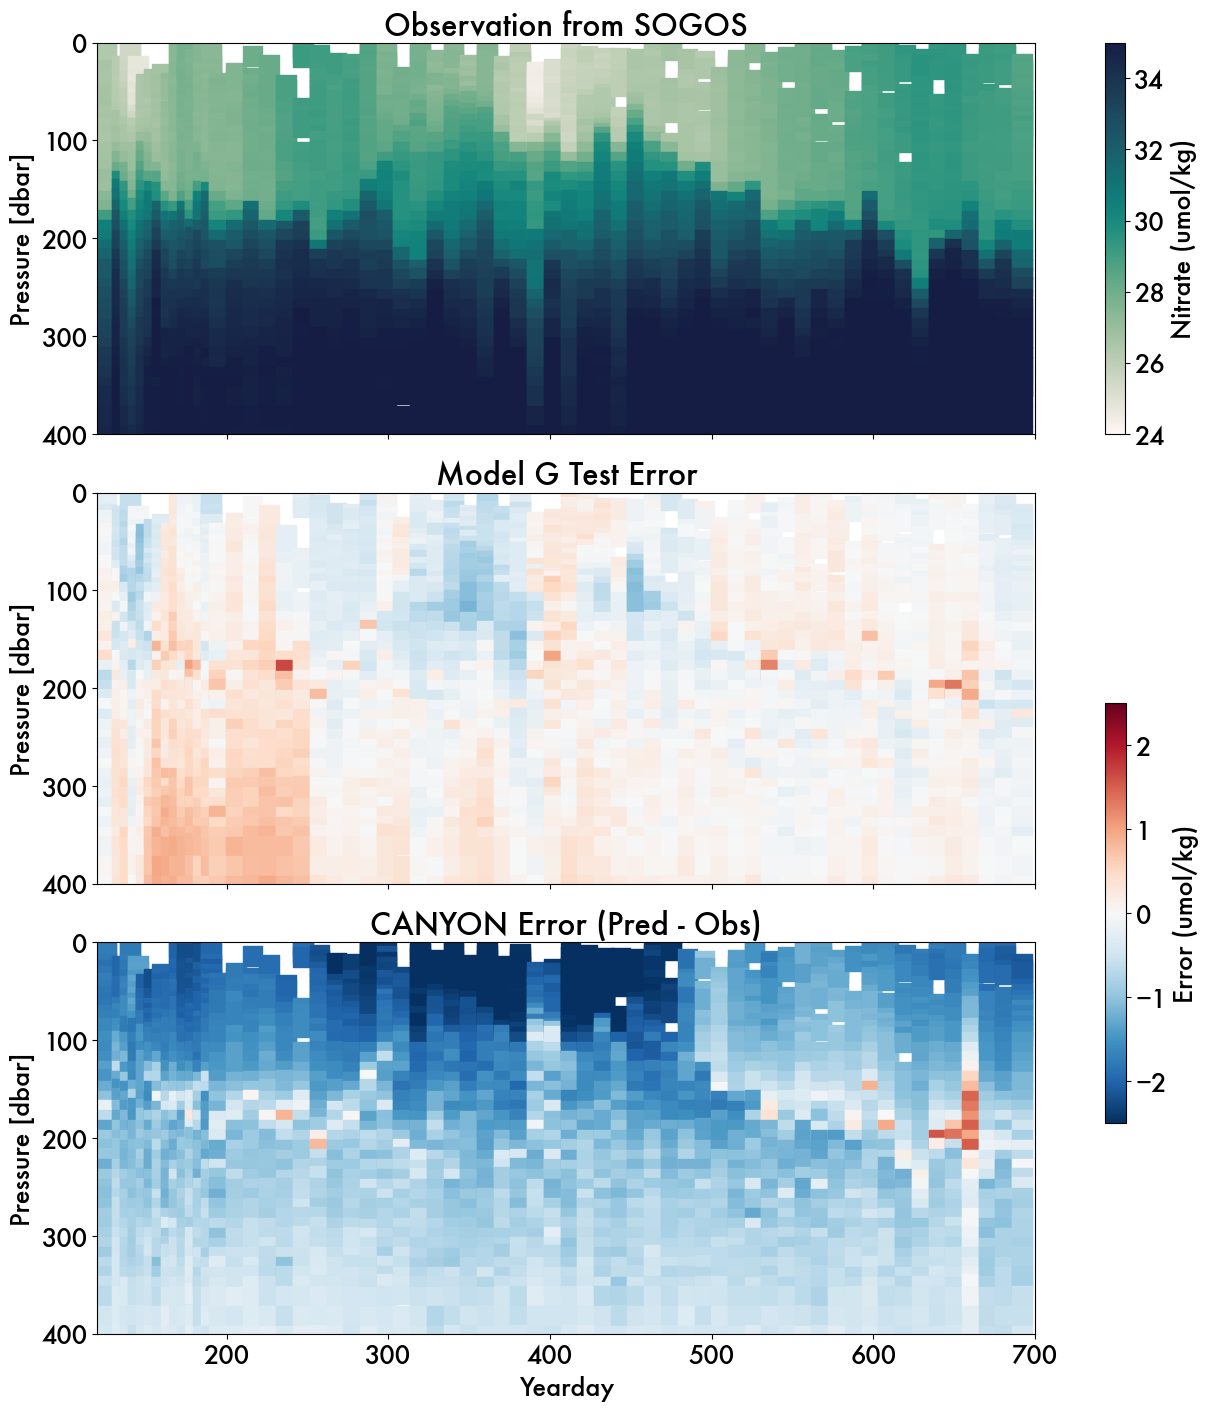

In [133]:
# * (Absolute, 3 subplots) Prediction, Obs, and Error Profiles
dat = RF_full.DF_err['Model_G']

fig, axs = plt.subplots(3,1, figsize=(12,14), layout='constrained', sharex=True)
axs = axs.flatten()

sca0 = axs[0].scatter(dat.yearday, dat.pressure, c=dat.nitrate, cmap=cmo.tempo, s=200, marker='s', vmin=24, vmax=35) #, vmin=0, vmax=0.005
axs[0].set_title('Observation from SOGOS')

sca1 = axs[1].scatter(dat.yearday, dat.pressure, c=dat.test_error, cmap='RdBu_r', s=200, marker='s',vmin=-2.5, vmax=2.5) #, vmin=0, vmax=0.005
axs[1].set_title('Model G Test Error') 

sca2 = axs[2].scatter(sogos_canyon.yearday, sogos_canyon.pressure, c=sogos_canyon.prediction_error, cmap='RdBu_r', s=200, marker='s', vmin=-2.5, vmax=2.5)
axs[2].set_title('CANYON Error (Pred - Obs)')


fig.colorbar(sca0, ax=axs[0:1]).set_label('Nitrate (umol/kg)')
# fig.colorbar(sca1, ax=axs[1]).set_label('Nitrate (umol/kg)')
fig.colorbar(sca1, ax=axs[1:], shrink=0.5).set_label('Error (umol/kg)')
# fig.colorbar(sca2, ax=axs[2], shrink=0.5).set_label('Error (umol/kg)')

for ax in axs:
    ax.invert_yaxis()
    ax.set_ylabel('Pressure [dbar]')
    ax.set_xlim([120,700])
    ax.set_ylim([400,0])


axs[2].set_xlabel('Yearday')

# plt.savefig('../figures/canyon_err.png', dpi=300, bbox_inches='tight')

[Text(181, 0, "Jul '19"),
 Text(273, 0, "Oct '19"),
 Text(365, 0, "Jan '20"),
 Text(456, 0, "Apr '20"),
 Text(548, 0, "Jul '20"),
 Text(639, 0, "Oct '20")]

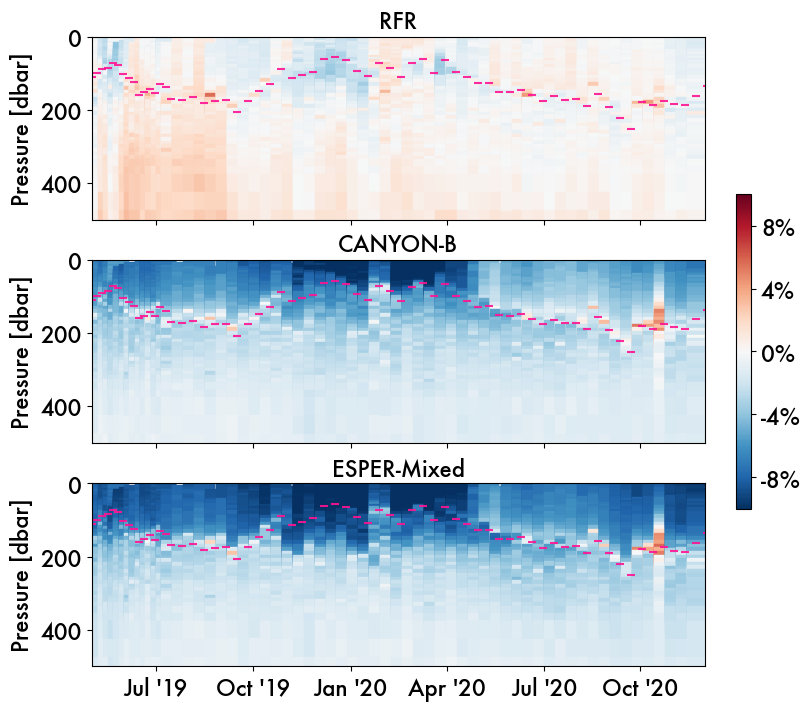

In [16]:
# # *PAPER FIG: RELATIVE 
# # (Absolute, 3 subplots) Prediction, Obs, and Error Profiles

# dat = RF_test['Model_G']

# fig, axs = plt.subplots(3,1, figsize=(8,7), layout='constrained', sharex=True)
# axs = axs.flatten()

# sca0 = axs[0].scatter(dat.yearday, dat.pressure, c=dat.test_relative_error, cmap='RdBu_r', s=200, marker='s', vmin=-.10, vmax=.10) #, vmin=0, vmax=0.005
# axs[0].set_title('RFR', fontsize=16)

# sca2 = axs[1].scatter(sogos_canyon.yearday, sogos_canyon.pressure, c=sogos_canyon.pred_relative_error, cmap='RdBu_r', s=200, marker='s', vmin=-.10, vmax=.10)
# axs[1].set_title('CANYON-B', fontsize=16)

# sca1 = axs[2].scatter(sogos_esper.yearday, sogos_esper.pressure, c=sogos_esper.pred_relative_error, cmap='RdBu_r', s=200, marker='s',vmin=-.10, vmax=.10) #, vmin=0, vmax=0.005
# axs[2].set_title('ESPER-Mixed', fontsize=16) 


# ticklist = [-0.08, -0.04, 0, 0.04, 0.08] 
# cbar = fig.colorbar(sca1, ax=axs[:], ticks=ticklist, shrink=0.5).ax.set_yticklabels(['-8%', '-4%', '0%', '4%', '8%'], fontsize=16) 
# # cbar.ax.set_yticklabels(['-8%', '-4%', '0%', '4%', '8%']) 

# for ax in axs:
#     ax.invert_yaxis()

#     ax.set_xlim([120,700])
#     ax.set_ylim([500,0])
#     ax.scatter(dav_6030.yearday, dav_6030.mld, c='deeppink', s=40, marker='_', alpha=0.9, label='MLD')
#     ax.set_ylabel('Pressure [dbar]')
# # axs[2].set_xlabel('Days since Jan 01 2019')

# # axs[0]
# xt = [181, 273, 365, 456, 548, 639]
# axs[2].set_xticks(xt)
# axs[2].set_xticklabels(['Jul \'19', 'Oct \'19','Jan \'20', 'Apr \'20', 'Jul \'20', 'Oct \'20'])

# # axs[2].set_xticklabels(str(sg.ytd2datetime(k))[-5:] for k in xt)
# # axs[2].set_xlabel('[Yearday]')

In [15]:
pd.read_csv('../working-vars/CANYON-prediction/wmo5906030_data.csv')

Unnamed: 0     yearday     lat     lon    pressure        CT         SA  \
0          27323  120.374294 -51.355  30.208   33.059998  3.646815  34.001027   
1          27324  120.374294 -51.355  30.208   35.230000  3.646676  34.001041   
2          27325  120.374294 -51.355  30.208   36.670000  3.646283  34.001036   
3          27328  120.374294 -51.355  30.208   46.730000  3.648244  34.001074   
4          27329  120.374294 -51.355  30.208   52.360000  3.639289  34.002073   
...          ...         ...     ...     ...         ...       ...        ...   
3303       30957  691.905764 -57.596  64.892  801.720030  2.179182  34.840148   
3304       30958  691.905764 -57.596  64.892  851.370000  2.156246  34.848747   
3305       30959  691.905764 -57.596  64.892  902.080000  2.134686  34.862375   
3306       30960  691.905764 -57.596  64.892  951.700000  2.086429  34.869113   
3307       30961  691.905764 -57.596  64.892  999.580000  2.070541  34.881759   

         oxygen     sigma0  log_buoyancy  ...   dist_maxb    Model_A  \
0     326.35095  26.900994    -19.750025  ...  117.879992  23.513882   
1     326.34912  26.901019    -15.410772  ...  115.709990  23.513882   
2     326.32490  26.901053    -15.336909  ...  114.269990  23.503534   
3     326.13754  26.900892    -13.446538  ...  104.209990  23.498182   
4     326.04580  26.902555    -13.096893  ...   98.579990  23.490950   
...         ...        ...           ...  ...         ...        ...   
3303  175.33665  27.698522    -13.153399  ... -552.340030  32.970772   
3304  176.85205  27.707240    -13.061677  ... -601.990000  33.005773   
3305  178.92215  27.719843    -13.003560  ... -652.700000  32.620363   
3306  180.15717  27.729116    -13.068774  ... -702.320000  32.494653   
3307  183.09941  27.740466    -13.068774  ... -750.200000  32.127783   

        Model_B    Model_C    Model_D    Model_E    Model_F    Model_G  \
0     23.917057  23.456406  23.991242  23.910289  24.164056  24.408469   
1     23.874999  23.446724  23.988052  23.909851  24.171068  24.408093   
2     23.848159  23.446585  23.991237  23.910956  24.158556  24.409034   
3     23.645077  23.440193  24.006588  23.906797  24.124431  24.424141   
4     23.533917  23.384158  23.991085  23.924937  24.065241  24.427613   
...         ...        ...        ...        ...        ...        ...   
3303  33.202558  33.304353  33.243148  33.274755  33.124749  33.240606   
3304  33.079670  32.986481  32.935322  32.951590  32.870003  32.933773   
3305  32.525743  32.660346  32.486420  32.521650  32.501158  32.496988   
3306  32.355977  32.382357  32.292761  32.322389  32.309339  32.314990   
3307  32.000356  31.831344  31.955411  31.967654  31.965432  31.948593   

      temperature   salinity  
0        3.642532  33.839691  
1        3.642532  33.839706  
2        3.642233  33.839703  
3        3.644846  33.839718  
4        3.636266  33.840687  
...           ...        ...  
3303     2.228182  34.670795  
3304     2.208523  34.679295  
3305     2.190395  34.692799  
3306     2.145229  34.699455  
3307     2.132661  34.711994  

[3308 rows x 28 columns]

In [ ]:
# * 3 Subplots: Prediction, Obs, and Error Profiles
# dat = RF_full.DF_err['Model_G']
dat = RF_test['Model_G']
tag = 'Model G'
type = 'absolute' # Choose absolute or relative errors here


fig, axs = plt.subplots(3,1, figsize=(8,7), layout='constrained', sharex=True)
axs = axs.flatten()

sca0 = axs[0].scatter(dat.yearday, dat.pressure, c=dat.nitrate, cmap=cmo.tempo, s=200, marker='s', vmin=24, vmax=35) #, vmin=0, vmax=0.005
axs[0].set_title('SOGOS Float Observation', fontsize=16) 


sca1 = axs[1].scatter(dat.yearday, dat.pressure, c=dat.test_prediction, cmap=cmo.tempo, s=200, marker='s', vmin=24, vmax=35) #, vmin=0, vmax=0.005
axs[1].set_title('RFR Prediction', fontsize=16)



fig.colorbar(sca0, ax=axs[0:2], shrink=0.5).set_label('Nitrate ' + umol_unit)

if type == 'absolute':
    sca2 = axs[2].scatter(dat.yearday, dat.pressure, c=dat.test_error, cmap='RdBu_r', s=200, marker='s', vmin=-2.5, vmax=2.5)
    axs[2].set_title('RFR Test Error', fontsize=16)
    fig.colorbar(sca2, ax=axs[2]).set_label('Error ' + umol_unit)

# elif type == 'relative':
#     sca2 = axs[2].scatter(dat.yearday, dat.pressure, c=dat.test_relative_error, cmap='RdBu_r', s=200, marker='s', vmin=-.06, vmax=.06)
#     axs[2].set_title('RFR Relative Error', fontsize=16)
#     ticklist = [-0.05, -0.025, 0, 0.025, 0.05] 
#     cbar = plt.colorbar(sca2, ax=axs[2], ticks=ticklist).set_label('Error ' + umol_unit)

for ax in axs[:]:
    ax.scatter(dav_6030.yearday, dav_6030.mld, c='deeppink', s=40, marker='_', alpha=0.9, label='MLD')

for ax in axs:
    ax.invert_yaxis()
    ax.set_xlim([120,700])

# axs[2].set_xlabel('Yearday')
axs[0].set_ylabel('Pressure [dbar]')


# xt = axs[2].get_xticks()
# axs[2].set_xticklabels(str(sg.ytd2datetime(k))[-8:] for k in xt)

xt = [181, 273, 365, 456, 548, 639]
axs[2].set_xticks(xt)
# axs[2].set_xticklabels(str(sg.ytd2datetime(k))[-5:] for k in xt)
# axs[2].set_xticklabels(['Jul \'19', 'Oct \'19','Jan \'20', 'Apr \'20', 'Jul \'20', 'Oct \'20'])

axs[2].set_xlabel('[Yearday]')

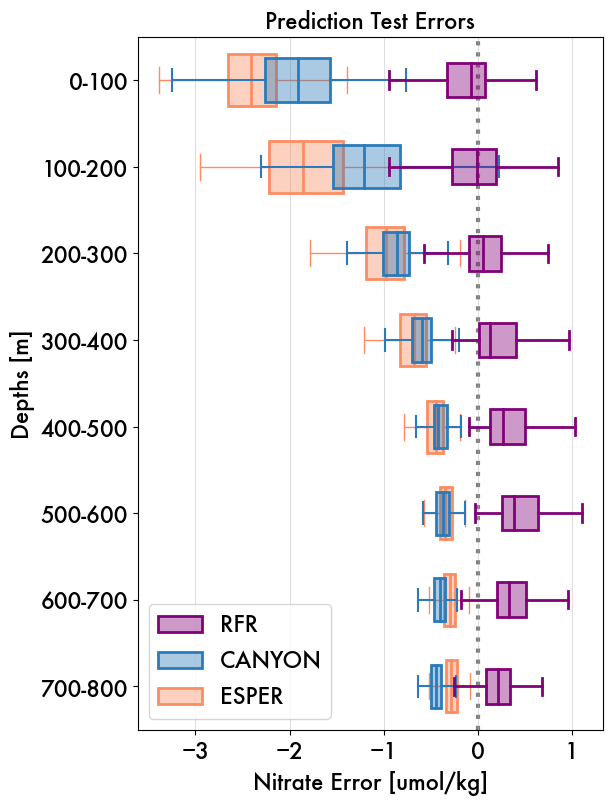

In [183]:
# Plot bias by depths, for CANYON/ESPER 
mod_one = 'RFR'
mod_two = 'CANYON'
mod_three = 'ESPER'

pressure_ranges = [(0, 100), (100, 200), (200, 300), (300, 400), 
                   (400, 500), (500, 600), (600, 700), (700, 800)]

bias_float = crf.get_depth_bias(sogos_float, pressure_ranges, var='test_error')
bias_canyon = crf.get_depth_bias(sogos_canyon, pressure_ranges, var='prediction_error')
bias_esper = crf.get_depth_bias(sogos_esper, pressure_ranges, var='prediction_error')

color_one = model_palettes['Model_G'] # sns.color_palette("Purples")[3]
color_two = model_palettes['Model_D']
color_three = model_palettes['Model_E']


# col_one = {'color':color_one, 'linewidth':1}
col_one = {'color':color_one, 'linewidth':1}
col_two = {'color':color_two, 'linewidth':1}
col_three = {'color':color_three, 'linewidth':1}

fig = plt.figure(figsize=(6,9))
# fig = plt.figure(figsize=(13,13))
ax = fig.gca()

# ESPER 
lw = 1
bplot_three = ax.boxplot(bias_esper.values(), vert=False, showfliers=False, widths=0.6, 
                    patch_artist=True, 
                    medianprops= {'color':color_three, 'linewidth':2},
                    capprops={'color':color_three, 'linewidth':lw},
                    whiskerprops={'color':color_three, 'linewidth':lw},
                    flierprops={'color':color_three, 'linewidth':lw},
                    boxprops = {'color':color_three, 'linewidth':2},
                    zorder=3)
for patch, color in zip(bplot_three['boxes'], [color_three]*10):
    patch.set_facecolor(matplotlib.colors.to_rgba(color, alpha=0.4))

# CANYON
lw = 1.5
bplot_two = ax.boxplot(bias_canyon.values(), vert=False, showfliers=False, widths=0.5, 
                    patch_artist=True, 
                    medianprops= {'color':color_two, 'linewidth':2},
                    capprops={'color':color_two, 'linewidth':lw },
                    whiskerprops={'color':color_two, 'linewidth':lw },
                    flierprops={'color':color_two, 'linewidth':lw},
                    boxprops = {'color':color_two, 'linewidth':2},
                    zorder=4)
for patch, color in zip(bplot_two['boxes'], [color_two]*10):
    patch.set_facecolor(matplotlib.colors.to_rgba(color, alpha=0.4))

# RFR
lw = 2
bplot_one = ax.boxplot(bias_float.values(), vert=False, showfliers=False, widths=0.4, 
                    patch_artist=True, 
                    medianprops= {'color':color_one, 'linewidth':lw},
                    capprops={'color':color_one, 'linewidth':lw },
                    whiskerprops={'color':color_one, 'linewidth':lw },
                    flierprops={'color':color_one, 'linewidth':lw },
                    boxprops = {'color':color_one, 'linewidth':2},
                    zorder=5)
for patch, color in zip(bplot_one['boxes'], [color_one]*10):
    patch.set_facecolor(matplotlib.colors.to_rgba(color, alpha=0.4))

ax.invert_yaxis()
ax.axvline(x=0, color='k', linestyle='dotted', linewidth=3, alpha=0.5, zorder=0)

labels = bias_float.keys()
plt.yticks(range(1, len(labels) + 1), labels)
plt.ylabel("Depths [m]")
plt.xlabel("Nitrate Error [umol/kg]")
plt.title("Prediction Test Errors")

ax.legend([bplot_one["boxes"][0], bplot_two["boxes"][0], bplot_three["boxes"][0]], [mod_one, mod_two, mod_three], loc='lower left')
ax.grid(axis='x', zorder=1, alpha=0.4)
# plt.savefig('../figures/canyon_esper_comparison_bydepth.png', dpi=300, bbox_inches='tight')

# PART 7: Final RFR Model Training


- Now, we will create one final RFR using the feature list, but this time incorporating the SOGOS float and full testing data




In [12]:
from mod_RFR import mltest as test
from mod_RFR import mlvalidation as validation
from mod_RFR import mltraining as training

In [14]:
import mod_RFR as rfr

In [18]:
# Train the final predictive model. 

ntrees = 1000
max_feats = 1/3
min_samples_split = 5
desc = 'full'
description = 'Hyperparameters: trees=' + str(ntrees) + ', max_features=' + str(max_feats)

print(description + '\n')

# Create the RF
RFR_Predictor = rfr.ModelVersion(ind_list = ['Model_G'])
new_training = pd.concat([training, validation, test])

for k in tqdm(['Model_G']): 
    [RFR_Predictor.models[k], RFR_Predictor.MAE[k], RFR_Predictor.IQR[k], 
     RFR_Predictor.r2[k], RFR_Predictor.DF_err[k], 
     RFR_Predictor.val_err[k]] = train_RF(var_list[k], 
                            new_training, validation, test, # validation and test datasets don't really matter here.
                            ntrees = ntrees, max_feats = max_feats,
                            min_samples_split=min_samples_split)
    

Hyperparameters: trees=1000, max_features=0.3333333333333333



100%|██████████| 1/1 [00:25<00:00, 25.49s/it]


# PART 8: Glider Prediction

In [145]:
# df_659 = pd.read_csv('../data/glider/mldata_sg659.csv')
# df_660 = pd.read_csv('../data/glider/mldata_sg660.csv')

In [7]:
sg659 = pd.read_csv('../data/glider/sg659_tsO2corr.csv')
sg660 = pd.read_csv('../data/glider/sg660_tsO2corr.csv')

In [8]:
file_path = '../data/glider/'
df_659 = pd.read_csv(file_path + 'sg659_tsO2corr.csv')
df_660 = pd.read_csv(file_path + 'sg660_tsO2corr.csv')

df_659 = df_659.replace(-np.inf, np.nan)
df_659 = df_659.replace(np.inf, np.nan)

df_660 = df_660.replace(-np.inf, np.nan)
df_660 = df_660.replace(np.inf, np.nan)

In [9]:
def add_yd_sinusoids(DF):
    DF['ydcos'] = [sg.get_ydsines(x)[0] for x in DF.yearday.values]
    DF['ydsin'] = [sg.get_ydsines(x)[1] for x in DF.yearday.values]

    return DF

df_659 = add_yd_sinusoids(df_659)
df_660 = add_yd_sinusoids(df_660)

In [20]:
len(sg.list_profile_DFs(df_660))

1004

In [28]:
reload(rfr)
from mod_RFR import model_list, var_list

In [29]:
# Method predict glider
def predict_glider(glidDF, Mdl, var_list, var_predict='nitrate'):
    X_glid= glidDF[var_list].to_numpy()
    Y_glid = Mdl.predict(X_glid)
    return Y_glid

df_659['nitrate_G'] = predict_glider(df_659, RFR_Predictor.models['Model_G'], var_list['Model_G'])
df_660['nitrate_G'] = predict_glider(df_660, RFR_Predictor.models['Model_G'], var_list['Model_G'])

In [30]:
df_659

Unnamed: 0                           juld     yearday      lat  \
0             3648  2019-04-30 13:59:56.205999872  119.583289 -51.4953   
1             4560  2019-04-30 13:59:58.707000064  119.583318 -51.4953   
2             5472  2019-04-30 14:00:03.707000064  119.583376 -51.4952   
3             6384  2019-04-30 14:00:06.206500096  119.583405 -51.4952   
4             7296  2019-04-30 14:00:08.706000128  119.583434 -51.4952   
...            ...                            ...         ...      ...   
862034      864575  2019-07-25 23:22:37.200999936  205.974042 -51.7062   
862035      865487  2019-07-25 23:22:27.200999936  205.973926 -51.7062   
862036      866399  2019-07-25 23:22:17.200999936  205.973810 -51.7062   
862037      867311  2019-07-25 23:22:07.200999936  205.973694 -51.7062   
862038      868223  2019-07-25 23:21:57.200999936  205.973579 -51.7062   

            lon  pressure        CT         SA      oxygen      buoyancy  ...  \
0       30.0471     4.035  3.579758  33.992030  329.116731 -6.526437e-06  ...   
1       30.0471     5.044  3.578758  33.991030  329.118250 -4.999368e-06  ...   
2       30.0472     6.053  3.580758  33.991030  329.153605  3.170546e-06  ...   
3       30.0472     7.062  3.581758  33.992030  329.761488  2.857285e-06  ...   
4       30.0472     8.070  3.582758  33.992030  330.009182 -4.583818e-07  ...   
...         ...       ...       ...        ...         ...           ...  ...   
862034  38.9821   957.539  2.163758  34.875034  180.973612  5.783918e-06  ...   
862035  38.9821   958.553  2.162758  34.876034  181.023786  4.248624e-06  ...   
862036  38.9821   959.566  2.162758  34.876034  181.070580  4.248337e-06  ...   
862037  38.9821   960.580  2.161758  34.877033  181.114731  4.248337e-06  ...   
862038  38.9820   961.593  2.161758  34.877033  181.139840  1.279869e-07  ...   

         profid  dive     sigma0     spice         AOU       o2sat  \
0       6590000     2  26.904773 -0.528216   -8.261820  320.854911   
1       6590000     2  26.904077 -0.529028   -8.253069  320.865181   
2       6590000     2  26.903886 -0.528816   -8.304066  320.849539   
3       6590000     2  26.904582 -0.528004   -8.922269  320.839220   
4       6590000     2  26.904486 -0.527898   -9.177797  320.831386   
...         ...   ...        ...       ...         ...         ...   
862034  6590911   462  27.730886 -0.045121  149.014392  329.988004   
862035  6590911   462  27.731762 -0.044509  148.969888  329.993675   
862036  6590911   462  27.731762 -0.044509  148.923098  329.993678   
862037  6590911   462  27.732639 -0.043898  148.884618  329.999349   
862038  6590911   462  27.732639 -0.043898  148.859512  329.999352   

        log_buoyancy     ydcos     ydsin  nitrate_G  
0                NaN -0.468626  0.883397  24.275499  
1                NaN -0.468627  0.883396  24.280235  
2         -12.661607 -0.468628  0.883396  24.276654  
3         -12.765639 -0.468628  0.883396  24.269754  
4                NaN -0.468628  0.883395  24.269983  
...              ...       ...       ...        ...  
862034    -12.060429 -0.919462 -0.393179  32.087978  
862035    -12.368915 -0.919463 -0.393178  32.057531  
862036    -12.368983 -0.919463 -0.393176  32.055678  
862037    -12.368983 -0.919464 -0.393174  32.032374  
862038    -15.871338 -0.919465 -0.393172  32.030069  

[862039 rows x 24 columns]

In [31]:
# # file_path = '../working-vars/nitrate-prediction/'
# df_659.to_csv('../working-vars/RF-glider/mlpred_sg659_G.csv')
# df_660.to_csv('../working-vars/RF-glider/mlpred_sg660_G.csv')

# END

## Overlay original float data with prediction. 

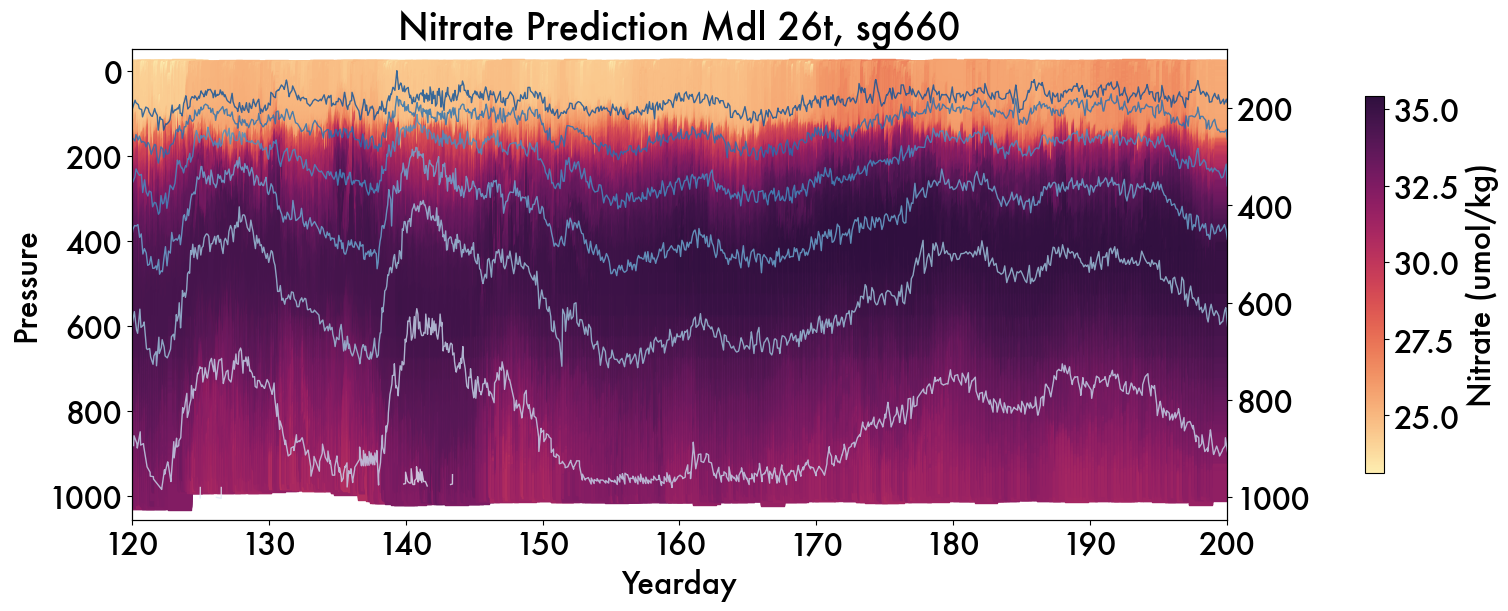

In [ ]:
# Plot density with density contours
# iso_dict = isoline_660.pop('27.2')
iso_dict = isoline_659
minday = 120
maxday = 200
df = df_660[(df_660.yearday <maxday) & (df_660.yearday > minday)]
tag = 'Mdl 26t, sg660'


# Create the scatter plot
fig, ax1 = plt.subplots(figsize=(15,6), layout='constrained')
sca = ax1.scatter(df['yearday'], df.pressure, c=df.nitrate_26t, cmap=cmo.matter, s=270, marker='s') #, vmin = 22.5, vmax=35.0)
ax1.set_ylabel('Pressure')

fig.colorbar(sca, ax=ax1, shrink=0.8).set_label('Nitrate (umol/kg)')

ax2 = ax1.twinx()
for ind, (key, val) in enumerate(iso_dict.items()):
    # Skipping lines for dates

    # Sort the DataFrame by 'yearday' to ensure the data points are in order
    val = val.sort_values(by = 'yearday')
    xval = []; yval = []

    # Iterate over the DataFrame and build the x and y values with NaN separators
    for i in range(len(val) - 1):
        xval.append(val.iloc[i]['yearday'])
        yval.append(val.iloc[i]['pressure'])
        if val.iloc[i + 1]['yearday'] - val.iloc[i]['yearday'] > 1:
            xval.append(None)
            yval.append(None)

    # Add the last data point
    xval.append(val.iloc[-1]['yearday'])
    yval.append(val.iloc[-1]['pressure'])

    ax2.plot(xval, yval, linewidth=1, label=key, color=palette[ind], alpha=0.8)

# ax2.legend(fontsize=14)
# labelLines(ax2.get_lines(), align=False, fontsize=18)
for ax in [ax1, ax2]:
    ax.invert_yaxis()
    ax.set_xlim([minday, maxday])

ax1.set_xlabel('Yearday')
plt.title('Nitrate Prediction ' + tag)

# ax1.axvline(x=187, color='c', linestyle='--', linewidth=1, alpha=0.9, zorder=3)
# ax1.axvline(x=194, color='c', linestyle='--', linewidth=1, alpha=0.9, zorder=3)
# Display the plot
plt.show()


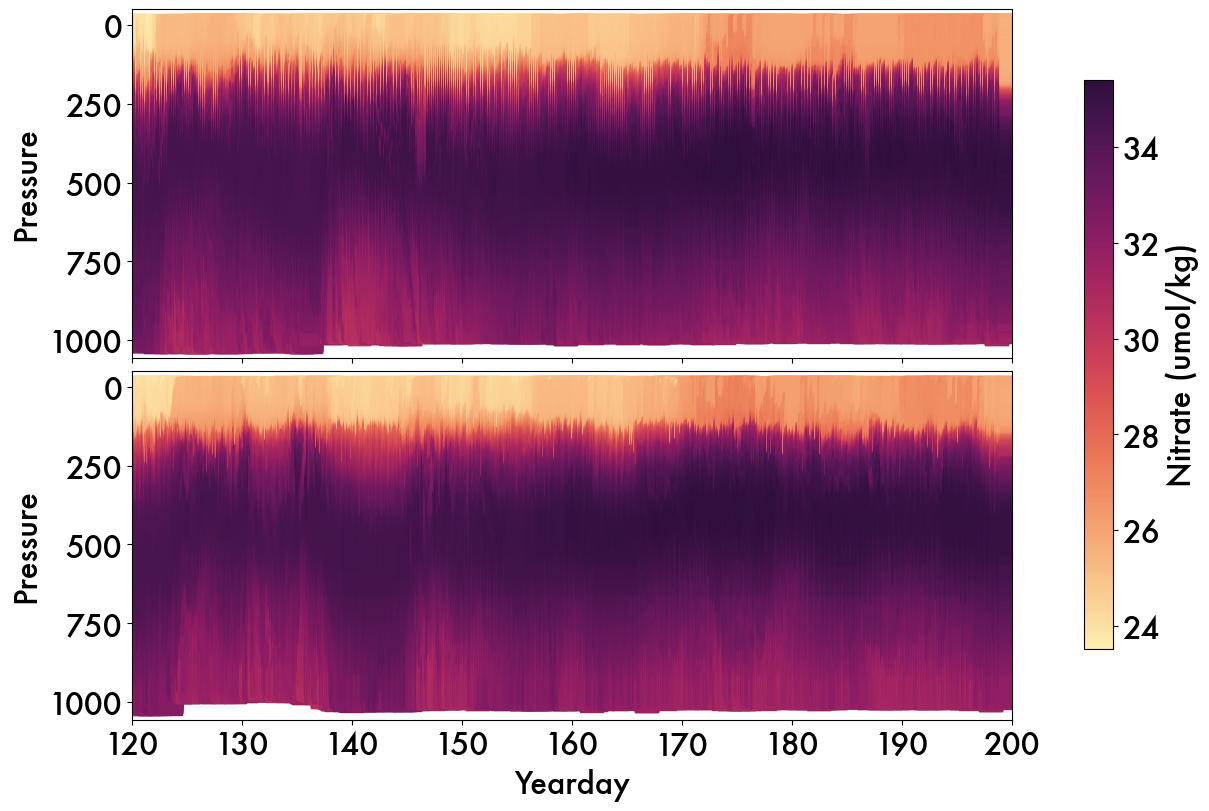

In [ ]:
# Plot density with density contours
iso_dict = isoline_660
minday = 120
maxday = 200
dat_660 = df_660[(df_660.yearday <maxday) & (df_660.yearday > minday)]
dat_659 = df_659[(df_659.yearday <maxday) & (df_659.yearday > minday)]
tag = 'Mdl 28t, sg660'


# Create the scatter plot
fig, axs = plt.subplots(2, 1, figsize=(12,8), sharex=True, layout='constrained')
axs = axs.flatten()

sca0 = axs[0].scatter(dat_659['yearday'], dat_659.pressure, c=dat_659.nitrate_28t, cmap=cmo.matter, s=270, marker='s') #, vmin = 22.5, vmax=35.0)
sca1 = axs[1].scatter(dat_660['yearday'], dat_660.pressure, c=dat_660.nitrate_28t, cmap=cmo.matter, s=270, marker='s') #, vmin = 22.5, vmax=35.0)

ax.set_ylabel('Pressure')
 
fig.colorbar(sca0, ax=axs[:], shrink=0.8).set_label('Nitrate (umol/kg)')

for ax in axs:
    ax.invert_yaxis()
    ax.set_xlim([minday, maxday])
    ax.set_ylabel('Pressure')

axs[1].set_xlabel('Yearday')
# plt.title('Nitrate Prediction ' + tag)

# Display the plot
plt.show()

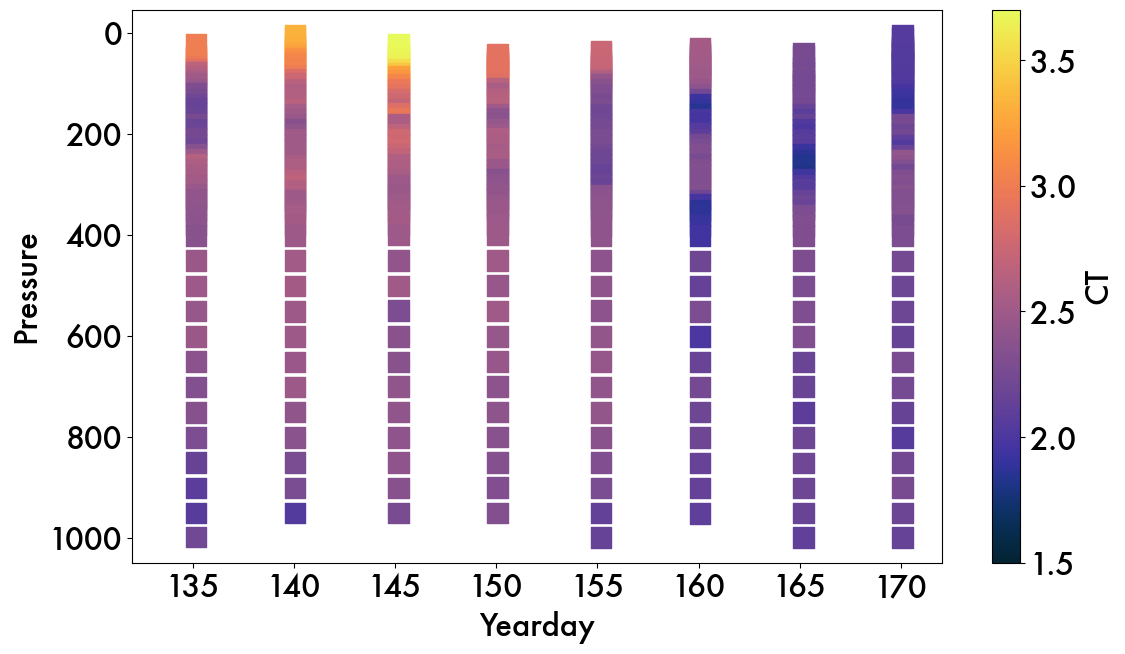

(800.0, 0.0)

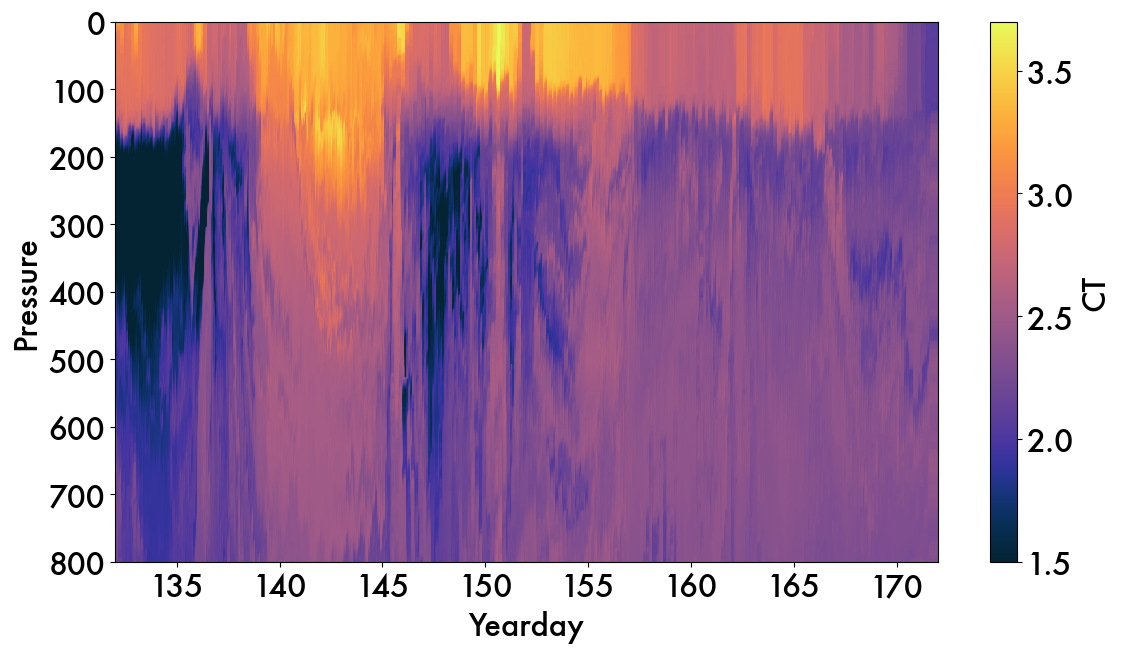

In [ ]:
# Float with glider
minday = 132
maxday = 172

# First plot float data
dat = test[(test.yearday <maxday) & (test.yearday > minday)]

fig  = plt.figure(figsize=(12,7), tight_layout=True)
ax = plt.gca()
sca = ax.scatter(dat.yearday, dat.pressure, c=dat.CT, cmap=cmo.thermal, s=220, marker='s', vmin=1.5, vmax=3.7) #, marker='s')
# ax.set_title('Float CT')

# ticklist = [1.5, 2.0, 2.5, 3.0, 3.5]
cbar = plt.colorbar(sca, ax=ax, ticks=ticklist).set_label('CT')
# cbar.set_yticklabels([1.5, 2.0, 2.5, 3.0, 3.5])

# plt.style.use("dark_background")

ax.invert_yaxis()
ax.set_ylabel('Pressure')
ax.set_xlabel('Yearday')
ax.set_xlim([minday, maxday])
plt.show()

######################
# Plot Glider

dat = df_660[(df_660.yearday <maxday) & (df_660.yearday > minday)]
# tag = '26t, glider 659'

fig  = plt.figure(figsize=(12,7), tight_layout=True)
ax = plt.gca()
sca = ax.scatter(dat.yearday, dat.pressure, c=dat.CT, cmap=cmo.thermal, s=100, marker='s', vmin=1.5, vmax=3.7)
# ax.set_title('Model ' + tag )

plt.colorbar(sca, ax=ax).set_label('CT')

ax.invert_yaxis()
ax.set_ylabel('Pressure')
ax.set_xlabel('Yearday')
ax.set_xlim([minday, maxday])
ax.set_ylim([800,0])





(800.0, 0.0)

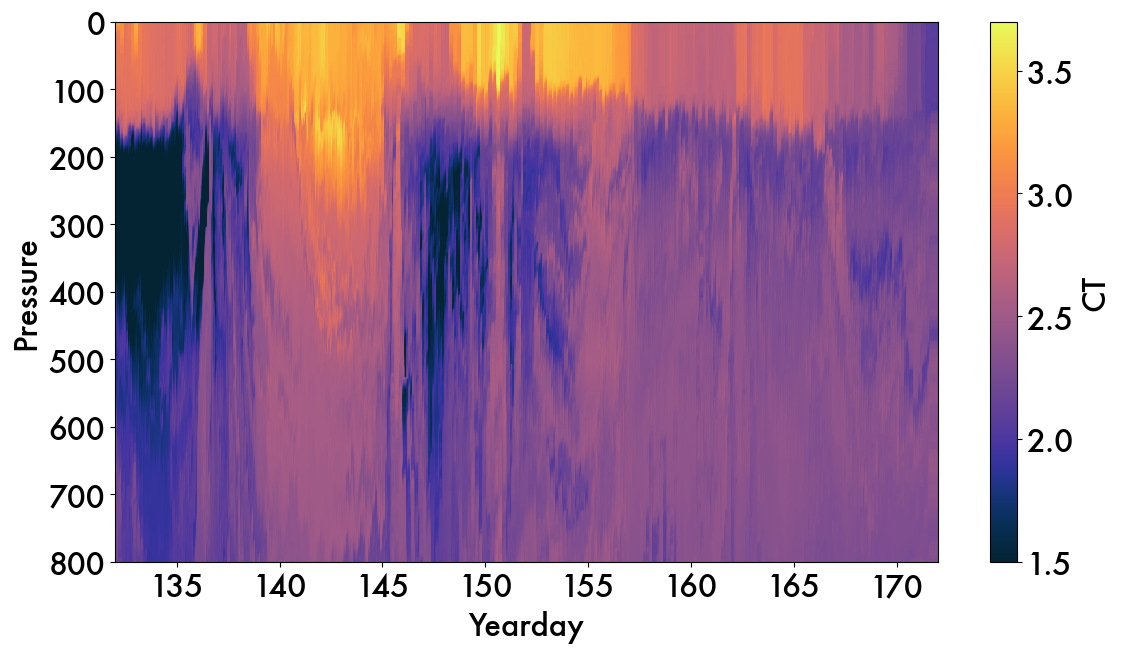

In [ ]:
# * Glider CT profile
minday = 132
maxday = 172

dat = df_660[(df_660.yearday <maxday) & (df_660.yearday > minday)]
# tag = '26t, glider 659'

fig  = plt.figure(figsize=(12,7), tight_layout=True)
ax = plt.gca()
sca = ax.scatter(dat.yearday, dat.pressure, c=dat.CT, cmap=cmo.thermal, s=100, marker='s', vmin=1.5, vmax=3.7)
# ax.set_title('Model ' + tag )

plt.colorbar(sca, ax=ax).set_label('CT')

ax.invert_yaxis()
ax.set_ylabel('Pressure')
ax.set_xlabel('Yearday')
ax.set_xlim([minday, maxday])
ax.set_ylim([800,0])

(800.0, 0.0)

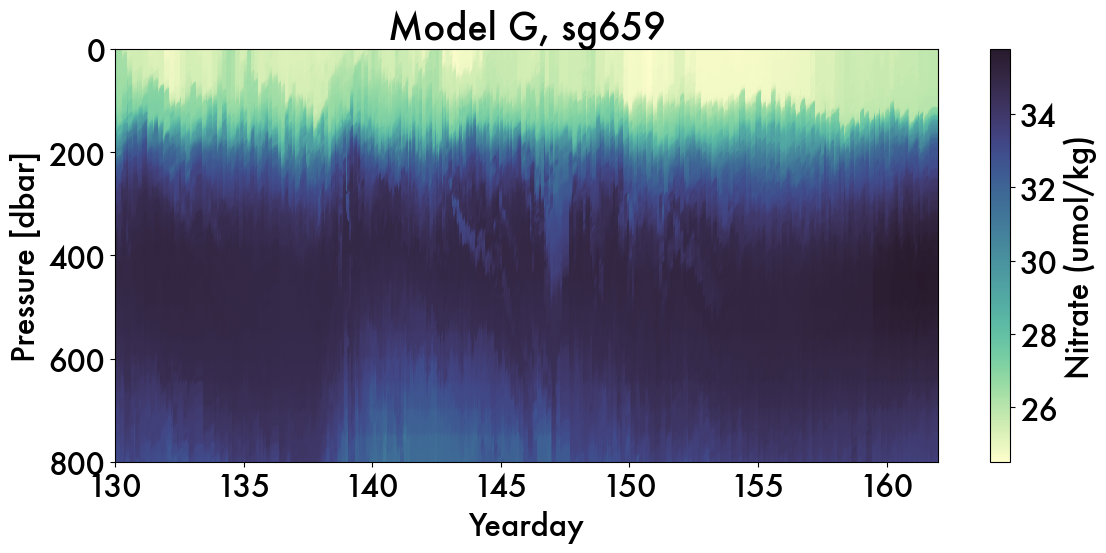

In [ ]:
# * Glider prediction nitrate profile
minday = 130
maxday = 162

dat = df_659[(df_659.yearday <maxday) & (df_659.yearday > minday)]
tag = 'Model G, sg659'


fig  = plt.figure(figsize=(12,6), tight_layout=True)
ax = plt.gca()
sca = ax.scatter(dat.yearday, dat.pressure, c=dat.nitrate_G, cmap=cmo.deep, s=50) #, vmin=1.5, vmax=3.6) #, marker='s')
ax.set_title(tag )

plt.colorbar(sca, ax=ax).set_label('Nitrate (umol/kg)')

ax.invert_yaxis()
ax.set_ylabel('Pressure [dbar]')
ax.set_xlabel('Yearday')
ax.set_xlim([minday, maxday])
ax.set_ylim([800,0])


# Glider ML Statistics

In [ ]:
len(sg.list_profile_DFs(df_659))

912

In [ ]:
importlib.reload(dfproc)

<module 'sgmod_DFproc' from '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/SOGOS-ML/scripts/sgmod_DFproc.py'>

In [141]:
dav_659 = dfproc.make_diveav(df_659) # from 7 to 13

number of profiles with no 10m data:  34
approx # of obs within profile that were averaged for final mlp:  5.55360824742268
number of nan mlds even where 10m exists:  73


In [142]:
dav_659 = dfproc.make_diveav(df_659) # from 5 to 15 dbar

number of profiles with no 10m data:  34
approx # of obs within profile that were averaged for final mlp:  5.55360824742268
number of nan mlds even where 10m exists:  73


In [ ]:
dav_660 = dfproc.make_diveav(df_660)

number of profiles with no 10m data:  81
approx # of obs within profile that were averaged for final mlp:  2.1917659804983747


In [143]:
temp = pd.read_csv('/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/SOGOS-ML/working-vars/glider/dav_659_fin24.csv')

In [144]:
len(sg.list_profile_DFs(temp))

912

In [ ]:
# Make new dataframe that is only the upper DF in the mixed layer 

# now in dfproc
# mldf_659 = pd.DataFrame()

# for i, prof in enumerate(dfproc.list_profile_DFs(df_659)):
#     mlp = dav_659.mld[i]
#     if mlp != np.nan:
#         upperprof = prof[prof.pressure<mlp].copy()

#         mlp_array = np.tile(mlp, upperprof.shape[0])
#         upperprof['mld'] = mlp_array
#         mldf_659 = pd.concat([mldf_659, upperprof], ignore_index=True)

mldf_659 = dfproc.make_mldf(df_659, dav_659)

yearday      lat      lon  pressure        CT         SA  \
0      119.616270 -51.4817  30.0739     4.035  3.565758  33.985030   
1      119.616328 -51.4817  30.0739     5.044  3.565758  33.986034   
2      119.616357 -51.4817  30.0739     6.053  3.565758  33.986034   
3      119.616385 -51.4817  30.0740     7.062  3.564758  33.986034   
4      119.616414 -51.4817  30.0740     8.070  3.563758  33.987034   
...           ...      ...      ...       ...       ...        ...   
46593  206.065014 -51.7020  38.9939   139.262  1.799758  34.098034   
46594  206.064898 -51.7020  38.9939   140.271  1.796758  34.101032   
46595  206.064782 -51.7021  38.9939   141.280  1.797758  34.102030   
46596  206.064667 -51.7021  38.9939   142.290  1.796758  34.106033   
46597  206.064580 -51.7021  38.9939   143.299  1.791758  34.109030   

           oxygen     sigma0  log_buoyancy     spice  ...     mncos     mnsin  \
0      330.053918  26.900568    -12.977491 -0.534645  ... -0.500000  0.866025   
1      330.290852  26.901363    -12.977491 -0.533936  ... -0.500000  0.866025   
2      330.425390  26.901363    -15.191113 -0.533936  ... -0.500000  0.866025   
3      330.587267  26.901458    -12.440718 -0.534042  ... -0.500000  0.866025   
4      330.744297  26.902345    -11.236404 -0.533441  ... -0.500000  0.866025   
...           ...        ...           ...       ...  ...       ...       ...   
46593  324.583938  27.139991    -10.434721 -0.621782  ... -0.866025 -0.500000   
46594  324.048930  27.142603    -11.141427 -0.619929  ... -0.866025 -0.500000   
46595  323.554817  27.143326    -10.872650 -0.619146  ... -0.866025 -0.500000   
46596  323.131232  27.146590    -10.455206 -0.616424  ... -0.866025 -0.500000   
46597  322.734685  27.149349    -10.523518 -0.614736  ... -0.866025 -0.500000   

       month   profid  wmoid    bbp470    bbp700  bbp695  nitrate_G      mld  
0          4  6590002    NaN  0.000469  0.000200  0.4636  24.152435  104.940  
1          4  6590002    NaN  0.000457  0.000190  0.4697  24.154595  104.940  
2          4  6590002    NaN  0.000445  0.000180  0.4758  24.154742  104.940  
3          4  6590002    NaN  0.000492  0.000213  0.5246  24.153960  104.940  
4          4  6590002    NaN  0.000475  0.000216  0.4758  24.151830  104.940  
...      ...      ...    ...       ...       ...     ...        ...      ...  
46593      7  6590911    NaN  0.000363  0.000110  0.1464  28.013817  144.309  
46594      7  6590911    NaN  0.000363  0.000120  0.1342  28.089606  144.309  
46595      7  6590911    NaN  0.000363  0.000110  0.1464  28.106280  144.309  
46596      7  6590911    NaN  0.000363  0.000120  0.1464  28.159023  144.309  
46597      7  6590911    NaN  0.000363  0.000116  0.1342  28.166114  144.309  

[46598 rows x 21 columns]

In [ ]:
nitrate_variance = []
mlpres = []
for prof in dfproc.list_profile_DFs(mldf_659):
    nitrate_variance.append(np.std(prof.nitrate_G))
    mlpres.append(prof.mld.mean())
nitrate_variance

[0.09848078691261018,
 0.11487833957309397,
 0.1051250345358102,
 0.11846076340140953,
 0.12185091045700784,
 0.1079588292703983,
 0.16362988242031207,
 0.1632790932337243,
 0.28268706122987025,
 0.2275748244040579,
 0.20490237502660086,
 0.2786992247278719,
 0.1692528024319526,
 0.17307103672487772,
 0.1191949995972077,
 0.267868272806021,
 0.24507364460642347,
 0.18796303086978278,
 0.1474224910244779,
 0.10362655199896308,
 0.17178699060268998,
 0.14930821366532152,
 0.11204975768793025,
 0.13155926671527624,
 0.1611756878256817,
 0.08477269693176528,
 0.12278457328929006,
 0.15405754991372397,
 0.25437436050647416,
 0.2685994042474995,
 0.25648674650185416,
 0.10516561142999757,
 0.22168392944595142,
 0.22894930508031175,
 0.28217977546125683,
 0.18768459118165787,
 0.2225643367902136,
 0.20694145654383572,
 0.2037341781978109,
 0.24718290502059362,
 0.22193420439996453,
 0.21445419224964726,
 0.22131775083854027,
 0.17160213163422583,
 0.25363783731491685,
 0.24042243793193216,
 0

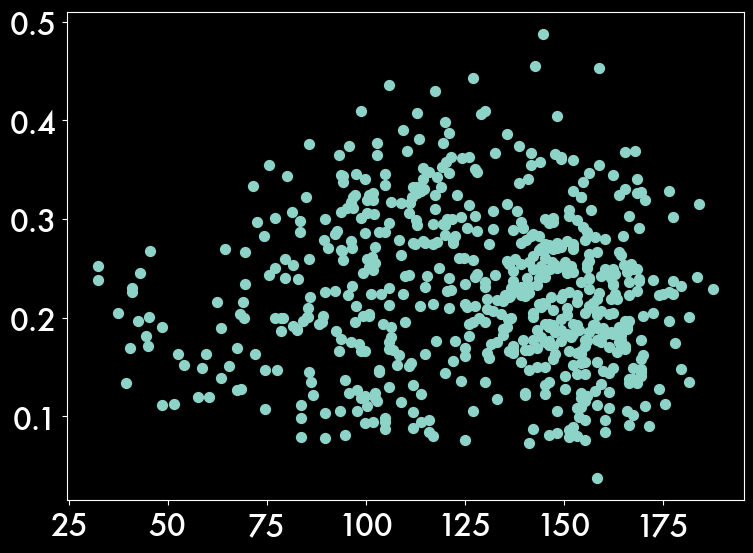

In [ ]:
fig = plt.figure(figsize=(8,6), layout='tight')
ax = fig.gca()

ax.scatter(mlpres, nitrate_variance, s=50) #, vmin=1.5, vmax=3.6) #, marker='s')

(200.0, 0.0)

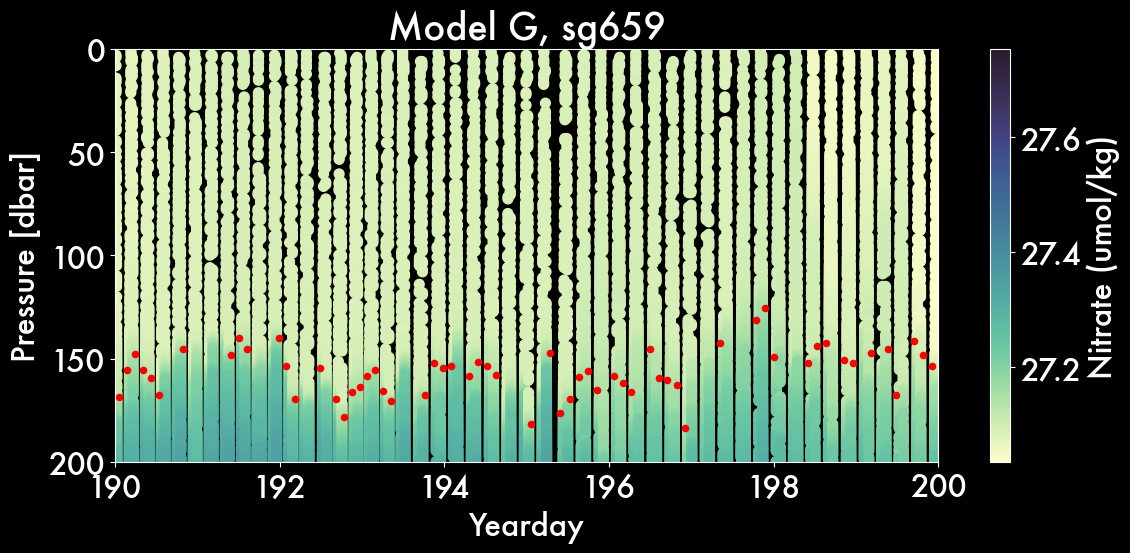

In [ ]:
# * Preidction, Obs, and Error Profiles
minday = 190
maxday = 200

dat = df_659[(df_659.yearday <maxday) & (df_659.yearday > minday)]
tag = 'Model G, sg659'


fig  = plt.figure(figsize=(12,6), tight_layout=True)
ax = plt.gca()
sca = ax.scatter(dat.yearday, dat.pressure, c=dat.sigma0, cmap=cmo.deep, s=50) #, vmin=1.5, vmax=3.6) #, marker='s')
ax.set_title(tag )

ax.scatter(dav_659.yearday, dav_659.mld, color='r', s=20)

plt.colorbar(sca, ax=ax).set_label('Nitrate (umol/kg)')

ax.invert_yaxis()
ax.set_ylabel('Pressure [dbar]')
ax.set_xlabel('Yearday')
ax.set_xlim([minday, maxday])
ax.set_ylim([200,0])



In [ ]:
dav_659.to_csv('../working-vars/glider/mld_659_1101.csv')
dav_660.to_csv('../working-vars/glider/mld_660_1101.csv')